# IAU - PHASE 1
### Martin Horský, Janka Krajčíková (50/50 effort)

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.metrics import normalized_mutual_info_score
from sklearn.impute import KNNImputer
from statsmodels.stats.power import TTestIndPower

# Phase 1-1: Data Description & Characteristics
## 1-1A: Structure Analysis

Data is saved in 4 csv files: connections, devices, processes, profiles. One row = one entry. Separator is tab. Key connecting all tables is imei, which means a unique device identifier. Some values (like iso for Namibia) are by default interpreted as NaN, therefore we have to specify the na_values parameter.

In [2]:
connections, devices, processes, profiles = pd.read_csv('data/connections.csv', sep='\t', keep_default_na=False, na_values=''), pd.read_csv('data/devices.csv', sep='\t', keep_default_na=False, na_values=''), pd.read_csv('data/processes.csv', sep='\t', keep_default_na=False, na_values=''), pd.read_csv('data/profiles.csv', sep='\t', keep_default_na=False, na_values='')

We define functions that will prove useful in data inspection later.

In [75]:
# we also define a function to count outliers, since there isn't a built-in method for that
def get_outliers(series: pd.Series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    return series[(series < q1 - 1.5 * iqr) | (series > q3 + 1.5 * iqr)]

In [76]:
def nmi_matrix(dataframe):
    nmi_matrix = pd.DataFrame(index=dataframe.columns, columns=dataframe.columns)
    for i, col1 in enumerate(dataframe.columns):
        for j, col2 in enumerate(dataframe.columns):
            if i == j:
                nmi_matrix.loc[col1, col2] = 1.0
            elif i > j:
                nmi_matrix.loc[col1, col2] = nmi_matrix.loc[col2, col1]
            else:
                nmi_matrix.loc[col1, col2] = normalized_mutual_info_score(dataframe[col1], dataframe[col2])
    return nmi_matrix

In [77]:
def categorical_dependency(dataframe):
    categorical_columns = dataframe.select_dtypes(include=['object', 'category']).columns
    cramers_v_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

    # Loop through each pair of categorical columns
    for i, col1 in enumerate(categorical_columns):
        for j, col2 in enumerate(categorical_columns):
            if col1 == col2:
                cramers_v_matrix.loc[col1, col2] = 1.0  # Cramér's V with itself is 1 (perfect association)
            elif i > j:
                # We already calculated this pair
                cramers_v_matrix.loc[col1, col2] = cramers_v_matrix.loc[col2, col1]
            else:
                # Create a contingency table
                contingency_table = pd.crosstab(dataframe[col1], dataframe[col2])
                # Perform the chi-squared test
                chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)          
                # Get the number of observations
                n = contingency_table.sum().sum()      
                # Calculate Cramér's V
                r, k = contingency_table.shape
                cramers_v = np.sqrt(chi2_stat / (n * (min(r, k) - 1)))
                # Store the Cramér's V value in the matrix
                cramers_v_matrix.loc[col1, col2] = cramers_v

    cramers_v_matrix = cramers_v_matrix.astype(float)
    return cramers_v_matrix

In [78]:
# we need to create a function that will assist us in visualizing the relationships
def mwra_dependency_num(df, target_column):
    groups = pd.qcut(df[target_column], q=10)
    binned_means = df.groupby(groups, observed=True)['mwra'].mean()
    binned_means.plot(kind='line', marker='o')
    
    plt.xticks(ticks=range(10), labels=[f'{i.left:.1f}' for i in binned_means.index])
    plt.yticks(ticks=np.arange(0, 1.1, 0.1))
    plt.xlabel(f'{target_column} value')
    plt.ylabel('Mean of mwra')

In [79]:
def mwra_dependency_cat(df, target_column, do_counts=False):
    group_means = df.groupby(target_column, observed=True)['mwra'].mean()
    if not do_counts: 
        group_means.plot(kind='bar')
        plt.yticks(ticks=np.arange(0, 1.1, 0.1))
        plt.ylabel('Mean of mwra')
    else:
        group_means_counts = pd.cut(group_means, bins=np.arange(0, 1.1, 0.1), include_lowest=True).value_counts()
        group_means_counts.sort_index(inplace=True)
        group_means_counts.plot(kind='bar')
        plt.xlabel('Mean of mwra')
        plt.ylabel(f'Number of {target_column}s')
    

### Connections
Initially we print the first few rows of the connections table to get a sense of the data.

In [81]:
connections.head()

,ts,imei,mwra,c.android.youtube,c.dogalize,c.android.gm,c.katana,c.android.chrome,c.raider,c.android.vending,c.UCMobile.intl,c.UCMobile.x86,c.updateassist
0,2018-05-05 10:00:00,3590433799317661107,0.0,11.65403,10.65335,10.48791,16.91620,5.04564,36.21508,14.24956,4.09319,15.20934,5.11764
1,2018-05-05 10:01:00,3590433799317662063,1.0,10.29551,10.46363,10.98438,15.65637,14.82931,24.83765,57.49911,23.94919,8.82448,44.13570
2,2018-05-05 10:02:00,863033069630348313,0.0,12.12831,9.53752,6.78080,6.98948,10.92433,3.29441,20.37891,52.55353,49.51037,99.75215
3,2018-05-05 10:03:00,359043379931766114,1.0,11.06419,11.55759,8.87744,11.84499,15.45902,24.78878,36.40299,25.77644,21.84167,65.17774
4,2018-05-05 10:04:00,3590433799317661842,1.0,12.08457,10.42860,9.82241,12.48869,12.85363,40.98237,74.13316,96.77450,18.48116,90.77304


We analyze the structure of the table.

In [82]:
print(f"There are {connections.shape[0]} entries with {connections.shape[1]} columns:\n {connections.columns.values}")

There are 15074 entries with 13 columns:
 ['ts' 'imei' 'mwra' 'c.android.youtube' 'c.dogalize' 'c.android.gm'
 'c.katana' 'c.android.chrome' 'c.raider' 'c.android.vending'
 'c.UCMobile.intl' 'c.UCMobile.x86' 'c.updateassist']


In [83]:
connections.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15074 entries, 0 to 15073
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ts                 15074 non-null  datetime64[ns]
 1   imei               15074 non-null  int64         
 2   mwra               15074 non-null  float64       
 3   c.android.youtube  15074 non-null  float64       
 4   c.dogalize         15074 non-null  float64       
 5   c.android.gm       15074 non-null  float64       
 6   c.katana           15074 non-null  float64       
 7   c.android.chrome   15074 non-null  float64       
 8   c.raider           15074 non-null  float64       
 9   c.android.vending  15074 non-null  float64       
 10  c.UCMobile.intl    15074 non-null  float64       
 11  c.UCMobile.x86     15074 non-null  float64       
 12  c.updateassist     15074 non-null  float64       
dtypes: datetime64[ns](1), float64(11), int64(1)
memory usage: 1.5

This dataset contains no missing values, as the number of non-null entries in each column matches the total row count. The first column holds object type values, representing timestamps, and will likely be converted to timestamp type during further processing. The second column stores int64 values, which represent the International Mobile Equipment Identity (IMEI) number. The third column is of type float64 despite containing only boolean values, which indicate malware-related activity. The other columns are of type float64  serving as input for evaluating mwra. 

The pair of first and second column (ts, imei) are keys for snapshot of the rest of values. The third column is the result of evaluation. 

In [84]:
connections.describe()

,ts,imei,mwra,c.android.youtube,c.dogalize,c.android.gm,c.katana,c.android.chrome,c.raider,c.android.vending,c.UCMobile.intl,c.UCMobile.x86,c.updateassist
count,15074,1.507400e+04,15074.000000,15074.000000,15074.000000,15074.000000,15074.000000,15074.000000,15074.000000,15074.000000,15074.000000,15074.000000,15074.000000
mean,2018-05-10 14:03:19.730662144,3.944186e+18,0.628367,10.649835,11.159652,9.960639,11.779597,9.983044,49.518952,50.033587,50.042579,49.858606,49.845721
min,2018-05-05 10:00:00,3.590434e+17,0.000000,1.023410,0.113470,0.022370,2.299720,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2018-05-07 23:59:15,8.630331e+17,0.000000,8.759405,9.342795,8.119385,10.424308,8.128787,24.551032,24.985702,24.950173,24.570863,24.762352
50%,2018-05-10 14:04:30,3.590434e+18,1.000000,10.527030,11.410130,9.868480,12.011270,9.935055,49.285175,50.404290,50.368725,49.839325,49.573495
75%,2018-05-13 04:00:45,8.630331e+18,1.000000,12.507920,13.140740,11.798052,13.362262,11.872960,74.746440,75.024978,74.937760,75.378667,74.872277
max,2018-05-15 18:14:00,8.630331e+18,1.000000,20.726030,19.477060,18.284120,19.684410,19.927250,100.000000,100.000000,100.000000,100.000000,100.000000
std,NaN,3.331167e+18,0.483257,2.541594,2.787612,2.564320,2.332968,2.609872,28.933385,28.855641,28.955827,29.024959,28.848587


From the method above, we can get a sense of distributions for each column. Especially mean close to the median suggest normal distribution.

In [85]:
print(f"There are {connections.shape[0] - connections.drop_duplicates().shape[0]} duplicates")

There are 179 duplicates


### Devices

In [86]:
devices.head()

,latitude,longitude,store_name,code,location,imei,country_device_share,continent
0,18.57677,-72.22625,Croix-des-Bouquets,HT,America/Port-au-Prince,3590433799317662113,bottom20%,America
1,-25.54073,152.70493,Maryborough,AU,Australia/Brisbane,8630330696303481107,60-80,Australia
2,50.88506,4.07601,Denderleeuw,BE,Europe/Brussels,8630330696303481461,60-80,Europe
3,48.15659,28.28489,Soroca,MD,Europe/Chisinau,3590433799317661016,bottom20%,Europe
4,-34.64966,-58.38341,Barracas,AR,America/Argentina/Buenos_Aires,3590433799317662253,60-80,America


In [87]:
print(f"There are {devices.shape[0]} entries with {devices.shape[1]} columns:\n {devices.columns.values}")


There are 2895 entries with 8 columns:
 ['latitude' 'longitude' 'store_name' 'code' 'location' 'imei'
 'country_device_share' 'continent']


In [88]:
devices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2895 entries, 0 to 2894
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   latitude              2895 non-null   float64 
 1   longitude             2895 non-null   float64 
 2   store_name            2895 non-null   object  
 3   code                  2895 non-null   object  
 4   location              2895 non-null   object  
 5   imei                  2895 non-null   int64   
 6   country_device_share  2895 non-null   category
 7   continent             2895 non-null   object  
dtypes: category(1), float64(2), int64(1), object(4)
memory usage: 161.5+ KB


There are no null values.

In [89]:
devices.describe()

,latitude,longitude,imei
count,2895.000000,2895.000000,2.895000e+03
mean,29.379861,9.846564,3.919073e+18
std,23.348693,73.262963,3.333461e+18
min,-54.800000,-156.474320,3.590434e+17
25%,14.933330,-60.931730,8.630331e+17
50%,36.766390,9.152140,3.590434e+18
75%,46.655810,71.211690,8.630331e+18
max,68.798330,178.004170,8.630331e+18


Latitude and longitude often act more as a categorical data instead of numerical, when it comes to analysis, as they split into categories rather than attributes growing in a linear fashion. IMEI is an id. Therefore the cell above provides no useful insight.

In [90]:
print(f"There are {devices.shape[0] - devices.drop_duplicates().shape[0]} duplicates")

There are 12 duplicates


### Processes

In [91]:
processes.head()

,ts,imei,mwra,p.android.chrome,p.android.documentsui,p.android.gm,p.system,p.android.packageinstaller,p.android.settings,p.android.externalstorage,...,p.dogalize,p.simulator,p.google,p.android.vending,p.inputmethod.latin,p.process.gapps,p.notifier,p.olauncher,p.gms.persistent,p.android.defcontainer
0,2018-05-05 10:00:00,3590433799317661107,0.0,7.41473,10.17656,14.80917,12.14702,11.55620,8.33912,14.02450,...,65.61120,50.11483,53.37584,68.21001,61.69014,42.31022,4.82212,90.97861,53.94759,20.98954
1,2018-05-05 10:01:00,3590433799317662063,1.0,9.40603,6.57378,6.06519,10.56643,16.74062,13.78434,7.57297,...,47.85939,64.64494,15.73793,58.42507,57.04862,40.09440,16.63539,30.11126,40.51207,64.61017
2,2018-05-05 10:02:00,863033069630348313,0.0,13.61225,11.73312,8.99679,10.79425,12.60312,10.78121,11.90788,...,52.33884,25.01553,42.88480,17.22521,13.74976,50.38813,42.62046,96.70838,43.37143,98.71501
3,2018-05-05 10:03:00,359043379931766114,1.0,8.14970,9.53996,8.28249,10.80629,13.97670,12.73047,11.64714,...,28.18437,55.22909,59.59616,78.03742,20.18875,20.99686,90.73121,86.05335,99.16606,95.92975
4,2018-05-05 10:04:00,3590433799317661842,1.0,8.20358,8.94156,8.62248,8.33003,13.44049,13.31239,11.40689,...,71.31165,60.24955,52.48479,13.37139,51.12877,70.85514,39.65245,29.01586,6.11403,65.87936


In [92]:
print(f"There are {processes.shape[0]} entries with {processes.shape[1]} columns:\n {processes.columns.values}")

There are 15074 entries with 23 columns:
 ['ts' 'imei' 'mwra' 'p.android.chrome' 'p.android.documentsui'
 'p.android.gm' 'p.system' 'p.android.packageinstaller'
 'p.android.settings' 'p.android.externalstorage' 'p.android.gms'
 'p.katana' 'p.browser.provider' 'p.dogalize' 'p.simulator' 'p.google'
 'p.android.vending' 'p.inputmethod.latin' 'p.process.gapps' 'p.notifier'
 'p.olauncher' 'p.gms.persistent' 'p.android.defcontainer']


In [93]:
processes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15074 entries, 0 to 15073
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ts                          15074 non-null  datetime64[ns]
 1   imei                        15074 non-null  int64         
 2   mwra                        15074 non-null  float64       
 3   p.android.chrome            15074 non-null  float64       
 4   p.android.documentsui       15074 non-null  float64       
 5   p.android.gm                15074 non-null  float64       
 6   p.system                    15074 non-null  float64       
 7   p.android.packageinstaller  15074 non-null  float64       
 8   p.android.settings          15074 non-null  float64       
 9   p.android.externalstorage   15074 non-null  float64       
 10  p.android.gms               15074 non-null  float64       
 11  p.katana                    15074 non-null  float64   

Same as the connections table, there are no null values in any columns. Other details are also the same as in the connections table.

In [94]:
processes.describe()

,ts,imei,mwra,p.android.chrome,p.android.documentsui,p.android.gm,p.system,p.android.packageinstaller,p.android.settings,p.android.externalstorage,...,p.dogalize,p.simulator,p.google,p.android.vending,p.inputmethod.latin,p.process.gapps,p.notifier,p.olauncher,p.gms.persistent,p.android.defcontainer
count,15074,1.507400e+04,15074.000000,15074.000000,15074.000000,15074.000000,15074.000000,15074.000000,15074.000000,15074.000000,...,15074.000000,15074.000000,15074.000000,15074.000000,15074.000000,15074.000000,15074.000000,15074.000000,15074.000000,15074.000000
mean,2018-05-10 14:03:19.730662144,3.944186e+18,0.628367,10.624031,10.088090,9.428202,10.055861,12.395920,11.247557,11.242832,...,50.848156,45.156014,49.467709,49.666323,49.639707,50.260145,50.290151,49.752762,49.817193,49.571407
min,2018-05-05 10:00:00,3.590434e+17,0.000000,1.596390,3.929200,1.529690,0.051170,5.165220,1.636750,1.918450,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2018-05-07 23:59:15,8.630331e+17,0.000000,8.704740,8.362568,7.834278,8.189795,11.167677,9.465430,9.340640,...,41.845320,37.395083,40.257945,24.730168,24.392198,25.262542,25.568478,25.376043,24.504192,24.162805
50%,2018-05-10 14:04:30,3.590434e+18,1.000000,10.369065,9.740430,9.165670,9.794255,12.409595,11.408155,11.333865,...,50.959360,45.116790,49.738240,49.261350,49.561340,50.040285,50.540960,49.815600,49.470135,50.005440
75%,2018-05-13 04:00:45,8.630331e+18,1.000000,12.449768,11.652207,10.747598,11.811273,13.617365,13.093542,13.186208,...,59.832208,52.859875,58.620773,74.841612,74.672930,75.275445,75.288210,74.053022,74.966813,74.796243
max,2018-05-15 18:14:00,8.630331e+18,1.000000,19.996520,18.814960,20.640630,21.245590,20.075470,19.985360,21.755430,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
std,NaN,3.331167e+18,0.483257,2.580956,2.380393,2.392442,2.646287,1.841499,2.572235,2.766107,...,13.234067,11.425622,13.496016,28.950774,28.891075,28.812835,28.812182,28.678112,28.951400,29.061716


We can again see that the mean is mostly close to the median, which suggests normal distribution. 

In [95]:
print(f"There are {processes.shape[0] - processes.drop_duplicates().shape[0]} duplicates")

There are 179 duplicates


### Profiles

In [96]:
profiles.head()

,name,mail,registration,job,ssn,company,current_location,username,imei,residence,user_id,address
0,Matthew Powell,floreseugene@yahoo.com,14 Mar 2024,NaN,219-60-6090,Hicks-Drake,"(Decimal('-27.447495'), Decimal('-43.231283'))",kcalderon,3590433799317661974,NaN,2401,"84859 Nunez Lock Suite 082\nWest Rossside, HI ..."
1,Nicole Richards,fthompson@gmail.com,2023-01-13,NaN,049-88-9351,"Nguyen, White and Lopez","(Decimal('39.235450'), Decimal('138.429324'))",pgarcia,8630330696303481198,"662 Christopher Point\nWest Matthew, VT 84352",1147,"9123 Traci Pines\nLindastad, ME 99569"
2,Andrew Smith,megan89@yahoo.com,17 Apr 2019,NaN,039-54-7186,Navarro-Goodman,"(Decimal('-22.094944'), Decimal('-141.211383'))",sramos,8630330696303482071,"9912 Jasmine Extension Suite 310\nDianeville, ...",459,"523 Suarez Port Apt. 013\nKellybury, MS 63150"
3,Shane Williams,osimmons@hotmail.com,2023-09-09,"Administrator, Civil Service",453-34-1867,"Brown, Compton and Thompson","(Decimal('39.9652785'), Decimal('-39.378417'))",ioneill,863033069630348826,NaN,1587,"4827 Morgan Mission\nWest Michaelborough, AL 1..."
4,Patricia Leach,prodriguez@yahoo.com,"01/30/2018, 00:00:00",NaN,785-50-4993,Pratt PLC,NaN,michaelhart,359043379931766403,NaN,2312,"48666 William View\nEricbury, OH 12135"


In [97]:
print(f"There are {profiles.shape[0]} entries with {profiles.shape[1]} columns:\n {profiles.columns.values}")

There are 2605 entries with 12 columns:
 ['name' 'mail' 'registration' 'job' 'ssn' 'company' 'current_location'
 'username' 'imei' 'residence' 'user_id' 'address']


In [98]:
profiles.describe()

,imei,user_id
count,2.605000e+03,2605.000000
mean,3.884606e+18,1334.530902
std,3.311186e+18,747.780003
min,3.590434e+17,0.000000
25%,8.630331e+17,679.000000
50%,3.590434e+18,1346.000000
75%,8.630331e+18,1995.000000
max,8.630331e+18,2604.000000


There are again only categorical data, so this cell doesn't provide any useful insight.

In [99]:
profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2605 entries, 0 to 2604
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   name              2605 non-null   object
 1   mail              2605 non-null   object
 2   registration      2605 non-null   object
 3   job               782 non-null    object
 4   ssn               2605 non-null   object
 5   company           2605 non-null   object
 6   current_location  2475 non-null   object
 7   username          2605 non-null   object
 8   imei              2605 non-null   int64 
 9   residence         912 non-null    object
 10  user_id           2605 non-null   int64 
 11  address           2214 non-null   object
dtypes: int64(2), object(10)
memory usage: 244.3+ KB


We can see all the columns are categorical. Further we can see that columns job and residence have a lot of missing values.

In [100]:
print(f"There are {profiles.shape[0] - profiles.drop_duplicates().shape[0]} duplicates")

There are 0 duplicates


## 1-1B: Analysis of Individual Attributes
For better results, analysis should be repeated for cleaned data.


* Connections
    - c.android.youtube
    - c.dogalize
* Devices
    - store_name
    - code
    - location
* Processes
    - p.system
    - p.android.gm
* Profiles
    - company
* Common
    - Between connections and processes: ts
    - Between all tables: imei
    - Predicted variable: mwra

### column: imei

In [101]:
for table in [connections, devices, processes, profiles]:
    print(table['imei'].describe(),'\nUnique values:', table['imei'].nunique(), '\n')

count    1.507400e+04
mean     3.944186e+18
std      3.331167e+18
min      3.590434e+17
25%      8.630331e+17
50%      3.590434e+18
75%      8.630331e+18
max      8.630331e+18
Name: imei, dtype: float64 
Unique values: 500 

count    2.895000e+03
mean     3.919073e+18
std      3.333461e+18
min      3.590434e+17
25%      8.630331e+17
50%      3.590434e+18
75%      8.630331e+18
max      8.630331e+18
Name: imei, dtype: float64 
Unique values: 499 

count    1.507400e+04
mean     3.944186e+18
std      3.331167e+18
min      3.590434e+17
25%      8.630331e+17
50%      3.590434e+18
75%      8.630331e+18
max      8.630331e+18
Name: imei, dtype: float64 
Unique values: 500 

count    2.605000e+03
mean     3.884606e+18
std      3.311186e+18
min      3.590434e+17
25%      8.630331e+17
50%      3.590434e+18
75%      8.630331e+18
max      8.630331e+18
Name: imei, dtype: float64 
Unique values: 496 



From the previous cell, only useful information is unique values (roughly 500 in each of them), since mean and quantiles don't matter for id. 

In [102]:
# get counts how many each specific imei is in each table
imei_counts = {
    'connections': connections['imei'].value_counts(),
    'devices': devices['imei'].value_counts(),
    'processes': processes['imei'].value_counts(),
    'profiles': profiles['imei'].value_counts()
}

In [103]:
imei_counts['connections'].describe()

count    500.000000
mean      30.148000
std        5.522961
min       12.000000
25%       26.000000
50%       30.000000
75%       34.000000
max       47.000000
Name: count, dtype: float64

In [104]:
imei_counts['devices'].describe()

count    499.000000
mean       5.801603
std        2.245638
min        1.000000
25%        4.000000
50%        6.000000
75%        7.000000
max       12.000000
Name: count, dtype: float64

In [105]:
imei_counts['processes'].describe()

count    500.000000
mean      30.148000
std        5.522961
min       12.000000
25%       26.000000
50%       30.000000
75%       34.000000
max       47.000000
Name: count, dtype: float64

In [106]:
imei_counts['profiles'].describe()

count    496.000000
mean       5.252016
std        2.192502
min        1.000000
25%        4.000000
50%        5.000000
75%        7.000000
max       13.000000
Name: count, dtype: float64

All the tables show to have roughly 500 distinct imei values. Processes and connections have way higher amount of entries per imei (30) than devices and profiles (about 5).

Text(0.5, 0, 'Number of entries per imei')

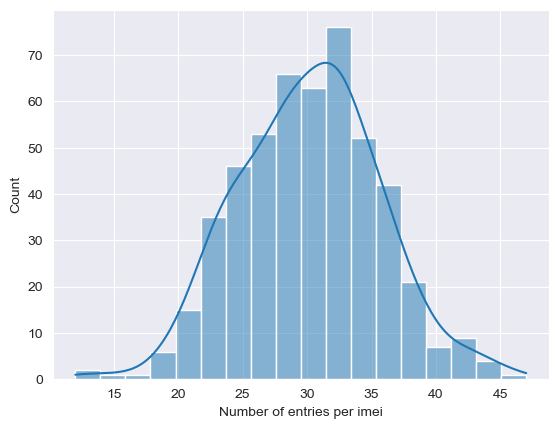

In [107]:
sns.histplot(imei_counts['connections'], kde=True)
plt.xlabel('Number of entries per imei')

Text(0.5, 0, 'Number of entries per imei')

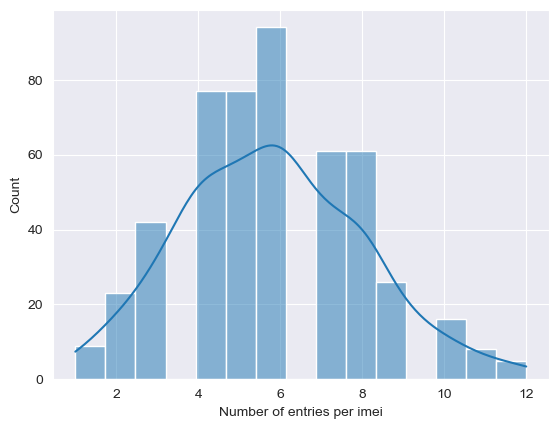

In [108]:
sns.histplot(imei_counts['devices'], kde=True)
plt.xlabel('Number of entries per imei')

Text(0.5, 0, 'Number of entries per imei')

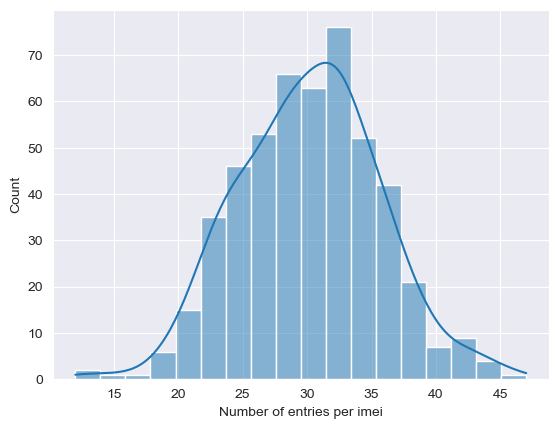

In [109]:
sns.histplot(imei_counts['processes'], kde=True)
plt.xlabel('Number of entries per imei')

Text(0.5, 0, 'Number of entries per imei')

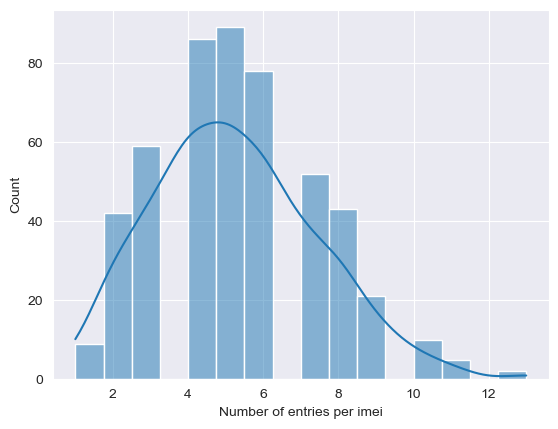

In [110]:
sns.histplot(imei_counts['profiles'], kde=True)
plt.xlabel('Number of entries per imei')

Distribution in tables connections and processes is normal, meaning not all devices have been tested the same amount of times. 
In profiles table, the distribution of imei is resembling normal, although slightly skewed. More entries per imei implies a device is used by multiple users.
In table devices, the distribution is also normal, also skewed. More entries per imei likely implies that device was sold multiple times, or something in that manner.


None of the columns seem to be skewed nor have unusual kurtosis.

In [111]:
for table_name, imei_count in imei_counts.items():
    print(f"{table_name}\n\tSkewness: {stats.skew(imei_count)}\n\tKurtosis: {stats.kurtosis(imei_count)}")

connections
	Skewness: 0.020269235872144426
	Kurtosis: 0.08682182515120385
devices
	Skewness: 0.25375336357679545
	Kurtosis: -0.1925534403016642
processes
	Skewness: 0.020269235872144426
	Kurtosis: 0.08682182515120385
profiles
	Skewness: 0.43709435332792845
	Kurtosis: -0.002120965891310611


In [112]:
for table_name, imei_count in imei_counts.items():
    print(f"{table_name}\n\tnumber of outliers: {get_outliers(imei_count).shape[0]}")

connections
	number of outliers: 3
devices
	number of outliers: 5
processes
	number of outliers: 3
profiles
	number of outliers: 2


For each of the tables, there are few outliers, appearing either too few times or too many times, but there isn't a significant amount of them.

### column: ts
timestamps appear in both connections and processes tables. 

They are in string format, so first we have to convert them to datetime format.

In [113]:
timestamps = {
    'connections': pd.to_datetime(connections['ts']), 
    'processes': pd.to_datetime(processes['ts'])
}

In [114]:
timestamps['connections'].describe()

count                            15074
mean     2018-05-10 14:03:19.730662144
min                2018-05-05 10:00:00
25%                2018-05-07 23:59:15
50%                2018-05-10 14:04:30
75%                2018-05-13 04:00:45
max                2018-05-15 18:14:00
Name: ts, dtype: object

In [115]:
timestamps['processes'].describe()

count                            15074
mean     2018-05-10 14:03:19.730662144
min                2018-05-05 10:00:00
25%                2018-05-07 23:59:15
50%                2018-05-10 14:04:30
75%                2018-05-13 04:00:45
max                2018-05-15 18:14:00
Name: ts, dtype: object

The describe method shows the same attributes for both tables. Let's check if the timestamps are the same.

In [116]:
timestamps['connections'].equals(timestamps['processes'])

True

Since they are the same, we don't have to check distribution for both tables.

The timestamps are in 1 minute intervals. We can't check if that's true until we remove duplicates (which would add 0min intervals and falsely rule out the assumption).

In [117]:
# have to ignore the first row, because that doesn't have a difference
timestamps['connections_diffs'] = timestamps['connections'].diff()[1:]
print(f"Before removing duplicates:\n\trows with 1minute difference: {sum(timestamps['connections'].diff() == '1min')}\n\tall rows have 1 min difference: {(timestamps['connections_diffs'] == '1min').all()}")
timestamps['connections_unique'] = pd.to_datetime(connections['ts'].drop_duplicates())
timestamps['connections_unique_diffs'] = timestamps['connections_unique'].diff()[1:]
print(f"After removing duplicates:\n\trows with 1minute difference: {sum(timestamps['connections_unique'].diff() == '1min')}\n\tall rows have 1 min difference: {(timestamps['connections_unique_diffs'] == '1min').all()}")
print(f"Since there is {timestamps['connections_unique'].shape[0]} unique timestamps, we can conclude that all the timestamps are in 1 minute intervals meaning uniform distribution.")

Before removing duplicates:
	rows with 1minute difference: 14894
	all rows have 1 min difference: False
After removing duplicates:
	rows with 1minute difference: 14894
	all rows have 1 min difference: True
Since there is 14895 unique timestamps, we can conclude that all the timestamps are in 1 minute intervals meaning uniform distribution.


Visual representation:

<Axes: xlabel='ts', ylabel='Count'>

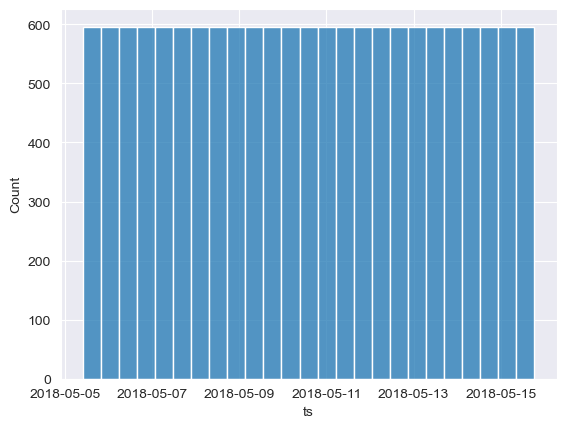

In [118]:
sns.histplot(timestamps['connections_unique'])

There naturally aren't any outliers as the data is uniformly distributed

### Column: connections - c.android.youtube

In [119]:
connections['c.android.youtube'].describe()

count    15074.000000
mean        10.649835
std          2.541594
min          1.023410
25%          8.759405
50%         10.527030
75%         12.507920
max         20.726030
Name: c.android.youtube, dtype: float64

Count is same as the total row count, which means there are no missing values. IQR is about 3.75, so we can clearly see, there are outliers (at least the maximum and minimum values are).

<Axes: xlabel='c.android.youtube', ylabel='Count'>

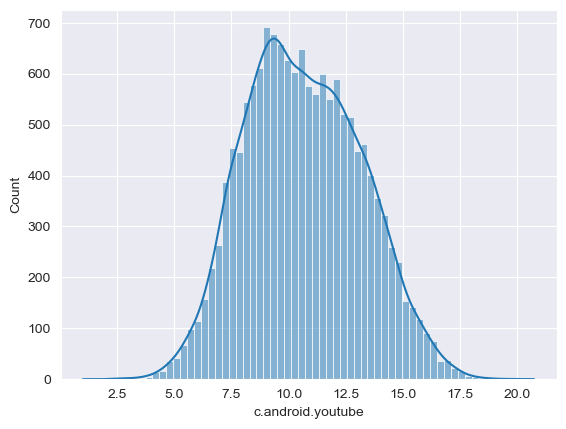

In [120]:
sns.histplot(connections['c.android.youtube'], kde=True)

data appears to be uniformly distributed

The data doesn't seem skewed. It shows slightly negative kurtosis.

In [121]:
print(f"Skewness: {stats.skew(connections['c.android.youtube'])}\nKurtosis: {stats.kurtosis(connections['c.android.youtube'])}")

Skewness: 0.15226536913358077
Kurtosis: -0.43960295056085474


In [122]:
print(f"There are {get_outliers(connections['c.android.youtube']).shape[0]} outliers in the column.")

There are 17 outliers in the column.


Let's see the outliers in a graph

<Axes: ylabel='c.android.youtube'>

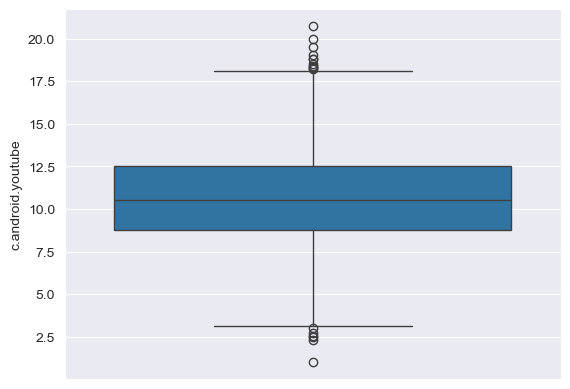

In [123]:
sns.boxplot(connections['c.android.youtube'])

### Column: connections - c.dogalize

In [124]:
connections['c.dogalize'].describe()

count    15074.000000
mean        11.159652
std          2.787612
min          0.113470
25%          9.342795
50%         11.410130
75%         13.140740
max         19.477060
Name: c.dogalize, dtype: float64

Count is the same as the total row count, indicating there are no missing values. The interquartile range (IQR) is about 3.8, which indicates a moderate spread of the middle 50% of the data. The minimum value is quite low (0.11), and the maximum value is 19.48, which suggests that there may be some outliers. The standard deviation is 2.79, showing moderate variability around the mean (11.16), and the median is very close to the mean, indicating normal distribution.

<Axes: xlabel='c.dogalize', ylabel='Count'>

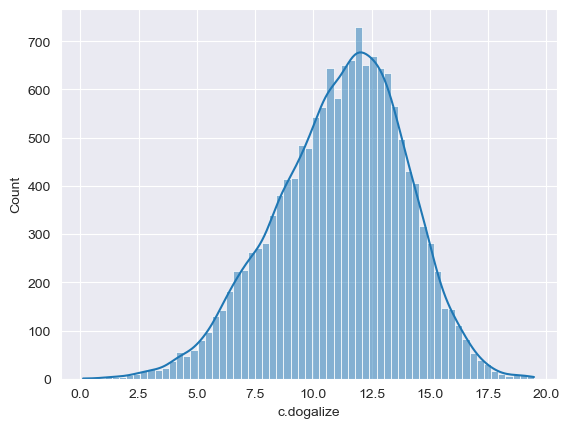

In [125]:
sns.histplot(connections['c.dogalize'], kde=True)

The data is normally distributed, but it seems to be slightly left skewed, so let's check the skewness.

In [126]:
stats.skew(connections['c.dogalize'])

-0.3408326674474093

Also check kurtosis while we at it, but that one seems normal

In [127]:
stats.kurtosis(connections['c.dogalize'])

-0.043511800762510155

Check amount of outliers

In [128]:
get_outliers(connections['c.dogalize']).shape[0]

115

<Axes: ylabel='c.dogalize'>

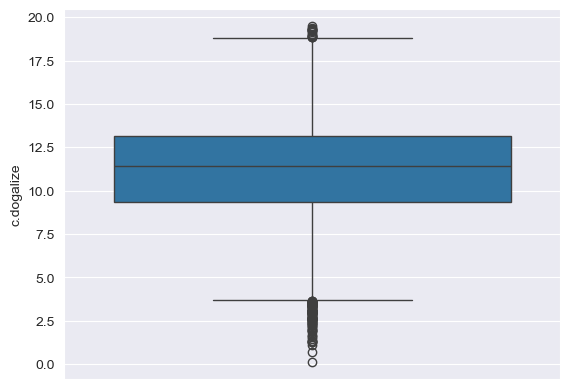

In [129]:
sns.boxplot(connections['c.dogalize'])

Higher number of outliers than before, but still below 1%

### Column: devices - store_name

In [130]:
devices['store_name'].describe()

count        2895
unique        937
top       Mampong
freq            9
Name: store_name, dtype: object

describes shows that only roughly third of the values are unique. Count is same as the total row count, indicating there are no missing values.

Text(0, 0.5, 'Number of stores')

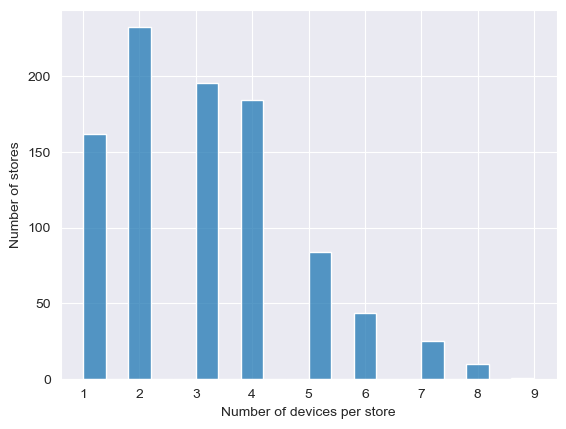

In [131]:
sns.histplot(devices['store_name'].value_counts())
plt.xlabel('Number of devices per store')
plt.ylabel('Number of stores')

Most stores have sold 1-4 devices, other than few exceptions. The distribution is right skewed.

In [132]:
stats.skew(devices['store_name'].value_counts())

0.7251188534572053

There are visibly some outliers. 

In [133]:
get_outliers(devices['store_name'].value_counts()).shape[0]

11

<Axes: ylabel='count'>

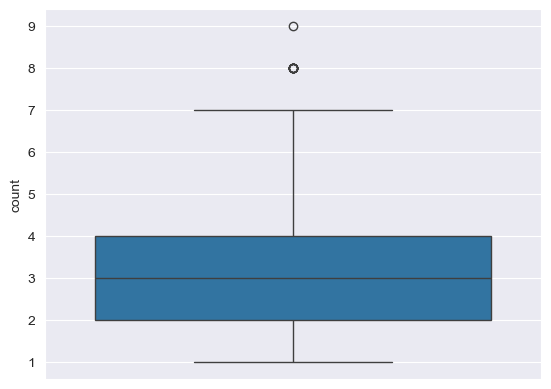

In [134]:
sns.boxplot(devices['store_name'].value_counts())

The biggest one, Mampong, being the only one at 9, while the other outliers are all at 8.

### Column: devices - code 
to be renamed country code

In [135]:
devices['code'].describe()

count     2895
unique     131
top         US
freq       508
Name: code, dtype: object

There are 131 distinct values and no missing values. The most frequent one is US, which appears in almost 20% of the rows.

In [136]:
devices['code'].value_counts().describe()

count    131.000000
mean      22.099237
std       53.511588
min        1.000000
25%        4.000000
50%        6.000000
75%       16.000000
max      508.000000
Name: count, dtype: float64

508 being the biggest value, while 75% of the values are below 16 is problematic.

Text(0, 0.5, 'Number of countries')

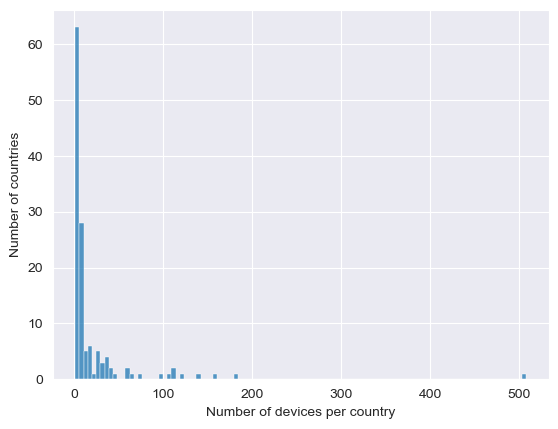

In [137]:
sns.histplot(devices['code'].value_counts())
plt.xlabel('Number of devices per country')
plt.ylabel('Number of countries')

The distribution is clearly disproportionate, due to very prominent outliers.

The data is highly skewed with high kurtosis.

In [138]:
print(f"Skewness: {stats.skew(devices['code'].value_counts())}\nKurtosis: {stats.kurtosis(devices['code'].value_counts())}")

Skewness: 6.366648462048307
Kurtosis: 51.15506691140475


<Axes: ylabel='count'>

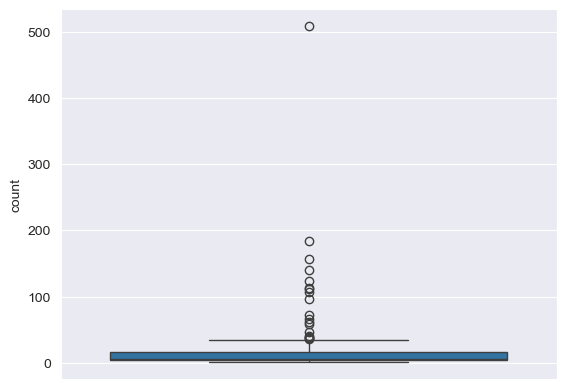

In [139]:
sns.boxplot(devices['code'].value_counts())

In [140]:
print(f"There are {get_outliers(devices['code'].value_counts()).shape[0]} outliers, which amount for {round(get_outliers(devices['code'].value_counts()).shape[0] / devices['code'].value_counts().shape[0] * 100, 1)}% of unique values and {round(sum(devices['code'].value_counts().nlargest(19)) / devices['code'].value_counts().sum() * 100, 1)}% of all the rows.")

There are 19 outliers, which amount for 14.5% of unique values and 70.2% of all the rows.


One solution might be to group all the non-outliers into one category.

In [141]:
outlier_countries = devices['code'].value_counts().nlargest(19).index
updated_country_code = devices['code'].apply(lambda x: x if x in outlier_countries else 'Other')
updated_country_code.value_counts()

code
Other    862
US       508
IN       184
RU       156
DE       140
GB       123
BR       113
CN       111
FR       107
IT        96
JP        72
ES        66
PH        62
ID        59
PK        47
TH        40
UA        39
AU        37
NG        37
NL        36
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='Count'>

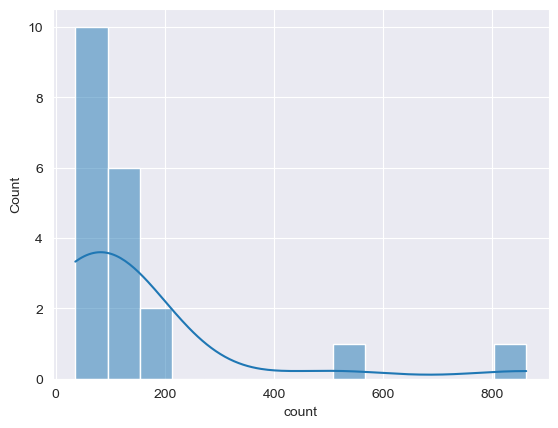

In [142]:
sns.histplot(updated_country_code.value_counts(), kde=True)

This has proven ineffective as well

Another option is grouping them by cumulative frequency.

In [143]:
country_counts = devices['code'].value_counts()
cumulative_freq=country_counts.cumsum() / country_counts.sum()
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

# Assign each country to a group (A, B, C, D, E) based on the cumulative frequency
group_labels = ['top20%', '20-40%', '40-60%', '60-80', 'bottom20%']
country_groups = pd.cut(cumulative_freq, bins=bins, labels=group_labels, include_lowest=True)
devices['country_device_share'] =devices['code'].map(country_groups)
devices['country_device_share'].value_counts()

country_device_share
60-80        623
20-40%       603
bottom20%    596
40-60%       565
top20%       508
Name: count, dtype: int64

### Column: location

In [144]:
devices['location'].describe()

count                 2895
unique                 179
top       America/New_York
freq                   218
Name: location, dtype: object

In [145]:
devices['location'].value_counts().describe()

count    179.000000
mean      16.173184
std       31.931777
min        1.000000
25%        3.000000
50%        5.000000
75%       10.500000
max      218.000000
Name: count, dtype: float64

<Axes: xlabel='count', ylabel='Count'>

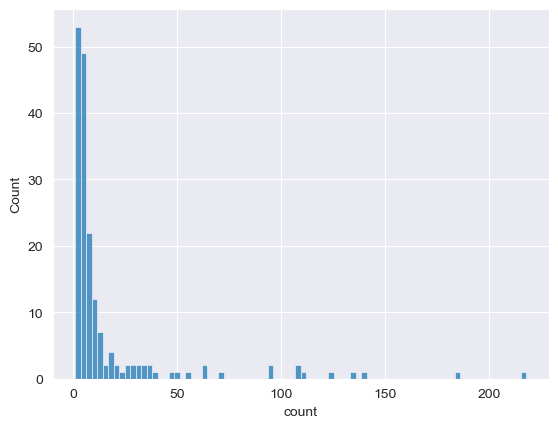

In [146]:
sns.histplot(devices['location'].value_counts())

In [147]:
print(f"Skewness: {stats.skew(devices['location'].value_counts())}\nKurtosis: {stats.kurtosis(devices['location'].value_counts())}")

Skewness: 3.7068891265244397
Kurtosis: 15.165283941188175


This column seems to have same problems as country code. Even if the distribution was better, the cardinality would be too high and highly correlated to store_name and other location-based columns, so we can just omit the city part of location. 

In [148]:
devices['continent'] = devices['location'].map(lambda x: x.split('/')[0])
devices['continent'].value_counts()

continent
Europe       930
America      851
Asia         780
Africa       262
Australia     37
Pacific       17
Indian        11
Atlantic       7
Name: count, dtype: int64

These are clearly better categories, as they are more evenly distributed and have less cardinality. Only Africa, Australia, Pacific, Indian and Atlantic should be merged into one category, as they are all very low in count.

<Axes: xlabel='continent', ylabel='count'>

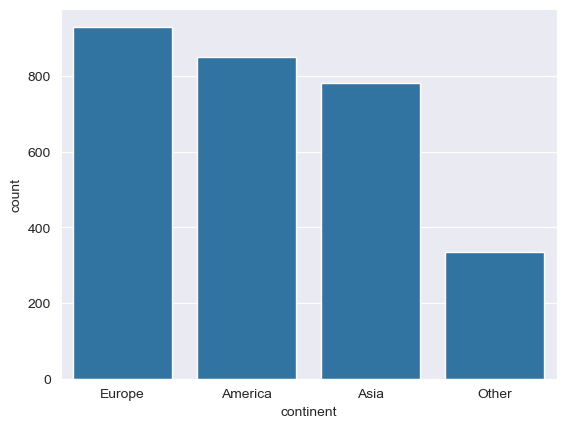

In [149]:
devices['continent'] = devices['continent'].map(lambda x: x if x not in ['Africa', 'Australia', 'Pacific', 'Indian', 'Atlantic'] else 'Other')
sns.barplot(devices['continent'].value_counts())

Smaller cardinality, no huge outliers, more practical for machine learning.

### Column: processes - p.system

In [150]:
processes['p.system'].describe()

count    15074.000000
mean        10.055861
std          2.646287
min          0.051170
25%          8.189795
50%          9.794255
75%         11.811273
max         21.245590
Name: p.system, dtype: float64

Count is the same as row count, indicating no missing values. Mean is close to median, suggesting normal distribution. IQR is about 3.62 which is far from min and max suggesting outliers. Standard deviation is roughly 25% of the median suggesting moderate variability around the median.

<Axes: xlabel='p.system', ylabel='Count'>

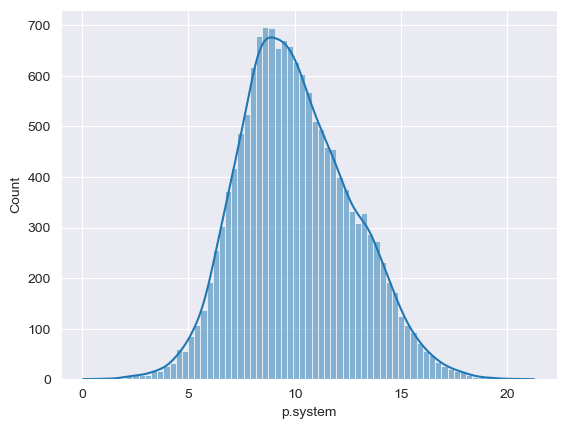

In [151]:
sns.histplot(processes['p.system'], kde=True)

Data appears to be normally distributed, not extraordinarily skewed nor having unusual kurtosis.

In [152]:
print(f"Skewness: {stats.skew(processes['p.system'])}\nKurtosis: {stats.kurtosis(processes['p.system'])}")

Skewness: 0.29895469791049273
Kurtosis: -0.04770725365747319


In [153]:
print(f"There are {get_outliers(processes['p.system']).shape[0]} outliers in the column.")

There are 105 outliers in the column.


<Axes: ylabel='p.system'>

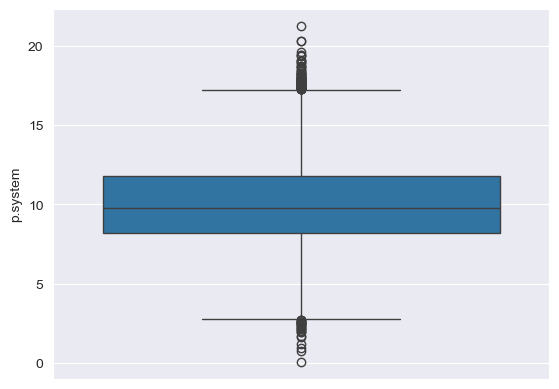

In [154]:
sns.boxplot(processes['p.system'])

### Column: processes - p.android.gm

In [155]:
processes['p.android.gm'].describe()

count    15074.000000
mean         9.428202
std          2.392442
min          1.529690
25%          7.834278
50%          9.165670
75%         10.747598
max         20.640630
Name: p.android.gm, dtype: float64

Count is the same as row count, indicating no missing values. Mean is close to median, suggesting normal distribution. IQR is about 2.91 which reveals few outliers for sure, as max and min aren't within 1.5 IQR of the 3rd and 1st quartile respectively.

<Axes: xlabel='p.android.gm', ylabel='Count'>

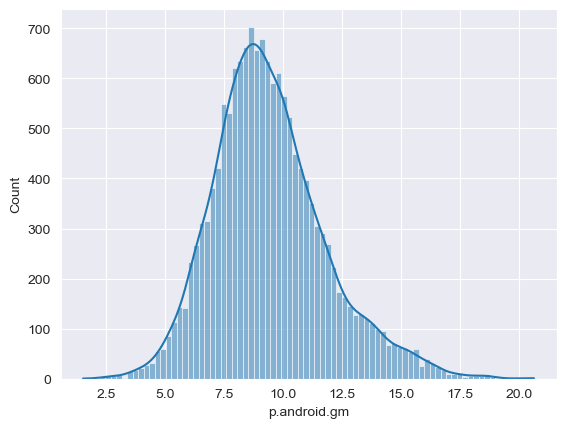

In [156]:
sns.histplot(processes['p.android.gm'], kde=True)

In [157]:
print(f"Skewness: {stats.skew(processes['p.android.gm'])}\nKurtosis: {stats.kurtosis(processes['p.android.gm'])}")

Skewness: 0.6239151528531606
Kurtosis: 0.7740757760005357


The column is in normal distribution. There is a right skew, but it's not too significant. The tails are slightly lighter as kurtosis suggests, but nothing significant either.

In [158]:
print(f"There are {get_outliers(processes['p.android.gm']).shape[0]} outliers in the column, which amounts for {round(get_outliers(processes['p.android.gm']).shape[0] / processes.shape[0] * 100)}% of the entries.")

There are 405 outliers in the column, which amounts for 3% of the entries.


<Axes: ylabel='p.android.gm'>

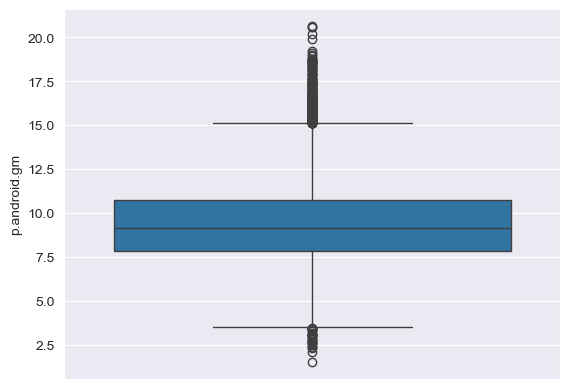

In [159]:
sns.boxplot(processes['p.android.gm'])

There is a higher percentage in outliers compared to other numerical columns previously observed, but that's good. Still nothing significant.

### Column: profiles - company

In [160]:
profiles['company'].describe()

count                 2605
unique                2464
top       Johnson and Sons
freq                     6
Name: company, dtype: object

The previous function shows 2464 out of 2605 companies are unique, meaning no real value for machine learning process later, as aren't doing LLMs, so we can't infer anything from the company.

In [161]:
profiles['company'].value_counts().describe()

count    2464.000000
mean        1.057224
std         0.295405
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         6.000000
Name: count, dtype: float64

Text(0, 0.5, 'Number of companies')

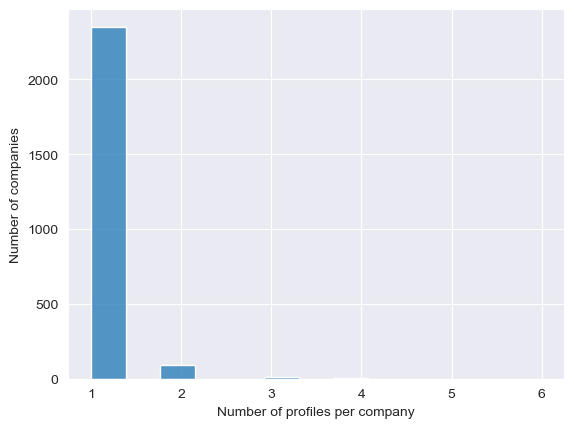

In [162]:
sns.histplot(profiles['company'].value_counts())
plt.xlabel('Number of profiles per company')
plt.ylabel('Number of companies')

As we can see, most of the companies have only one profile, which wouldn't be useful for machine learning.

### Predicted variable

<Axes: ylabel='count'>

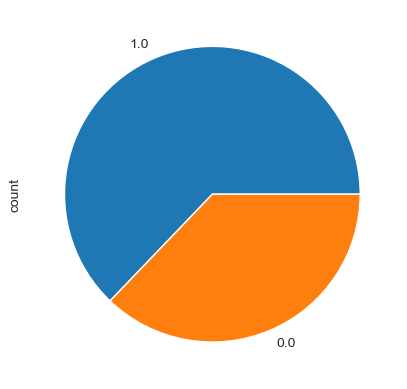

In [163]:
connections.mwra.value_counts().plot(kind='pie')

## 1-1C Column relationships analysis

### Connections Table
This table has mostly numerical values, therefore we cannot infer correlations at a simple glance. Let's try to visualize it better.

Pairplot wouldn't work for this many entries.

Just a quick example why it wouldn't work:


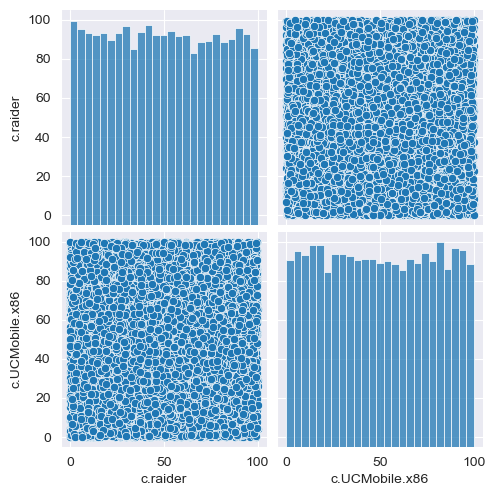

In [164]:
print("Just a quick example why it wouldn't work:")
sns.pairplot(connections[['c.raider', 'c.UCMobile.x86']])
plt.show()

<Axes: >

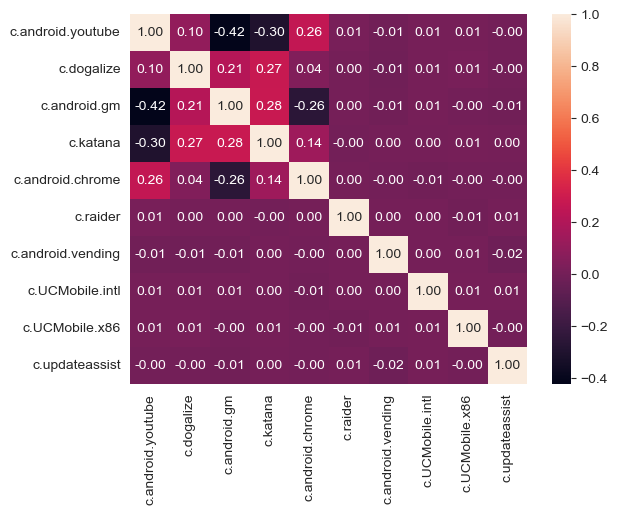

In [165]:
sns.heatmap(connections.iloc[:, 3:].corr(), annot=True, fmt=".2f")

Heatmap shows that there are almost no significant correlations between the columns. There is one though, a moderate correlation between c.android.youtube and c.android.gm. We may need to keep track of that one in further analysis.

### Devices table
Columns likely to be correlated/associated/dependent are all location columns in devices table. 

We can test it with Cramér's V test that . It calculates correlations between categorical values. The higher chi-squared statistic and the closer p-value is to 0, the more likely the columns are correlated.

In [166]:
categorical_dependency(devices[['store_name', 'location', 'code']])

,store_name,location,code
store_name,1.0,1.000000,1.000000
location,1.0,1.000000,0.996146
code,1.0,0.996146,1.000000


Test has shown that these values are clearly dependent. That's apparent, as store is in a city, which is in a country, therefore we can infer that if we know the store, we can infer the city and the country.

In [167]:
nmi_matrix(devices[['store_name', 'location', 'code']])

,store_name,location,code
store_name,1.0,0.771398,0.716843
location,0.771398,1.0,0.941377
code,0.716843,0.941377,1.0


Just to be sure, we confirmed the findings with (normalized) mutual information.

In [168]:
# since they are all strongly tied in together, we should keep only continent as it's the only one with reasonable cardinality. 'code' with 131 unique values for 2895 rows is too much for machine learning.
devices['store_name'].nunique(), devices['location'].nunique(), devices['code'].nunique(), devices['continent'].nunique(), 

(937, 179, 131, 4)

Newly made columns continent and country_device_share are also likely to be correlated, as countries with more share are likely to be in the continents with most share. 

In [169]:
pd.crosstab(devices['country_device_share'], devices['continent'])

continent,America,Asia,Europe,Other
country_device_share,,,,
top20%,505,0,0,3
20-40%,0,239,364,0
40-60%,113,183,266,3
60-80,88,233,170,132
bottom20%,145,125,130,196


From the table, there seems to be a correlation. America is the only continent with a significant amount of countries in the top 20% share. Asia and Europe are mostly in the 20-80 categories and the other ones are mostly in the bottom 20%. Let's test the correlation also with chi-square test.

In [170]:
categorical_dependency(devices)

,store_name,code,location,country_device_share,continent
store_name,1.0,1.000000,1.000000,1.0000,1.000000
code,1.0,1.000000,0.996146,1.0000,0.979756
location,1.0,0.996146,1.000000,1.0000,1.000000
country_device_share,1.0,1.000000,1.000000,1.0000,0.497800
continent,1.0,0.979756,1.000000,0.4978,1.000000


Test has shown that these values are also clearly tied together with the original columns. They are dependent on each other quite a lot as well, as cramer's v is 0.5.

### Processes table
Processes table, like connections, has mostly numerical values, so we also need to visualize all the correlations.

As we've learned, pair plot for this many entries is not useful, so we'll skip that step.

In [171]:
processes.iloc[:, 3:].corr()

,p.android.chrome,p.android.documentsui,p.android.gm,p.system,p.android.packageinstaller,p.android.settings,p.android.externalstorage,p.android.gms,p.katana,p.browser.provider,p.dogalize,p.simulator,p.google,p.android.vending,p.inputmethod.latin,p.process.gapps,p.notifier,p.olauncher,p.gms.persistent,p.android.defcontainer
p.android.chrome,1.000000,0.092605,-0.142825,0.107323,-0.053750,-0.319664,-0.460702,0.002020,0.083095,0.004421,-0.019596,0.003181,-0.000285,0.005803,0.003555,-0.003331,0.000164,0.012680,-0.013641,0.014438
p.android.documentsui,0.092605,1.000000,0.284195,0.367432,-0.044438,0.186383,0.349029,0.002251,-0.086736,0.003548,-0.013409,-0.003067,-0.008564,0.007553,-0.007125,-0.008410,0.006735,0.005227,-0.011289,-0.000301
p.android.gm,-0.142825,0.284195,1.000000,0.216030,0.084486,0.088121,0.223952,0.007772,-0.042687,-0.005163,0.009158,-0.004271,-0.006233,-0.006106,-0.013816,-0.009139,0.004707,-0.010127,0.002990,-0.001038
p.system,0.107323,0.367432,0.216030,1.000000,0.091450,0.316435,0.153111,0.000045,-0.067163,0.005880,-0.002051,0.005221,-0.005040,0.007021,-0.007232,-0.013476,0.011425,-0.003141,-0.010407,-0.002573
p.android.packageinstaller,-0.053750,-0.044438,0.084486,0.091450,1.000000,0.045652,-0.035798,0.013746,-0.077426,-0.015567,-0.003735,-0.001432,-0.001099,-0.004906,0.010038,0.019666,0.000689,-0.008751,0.008549,-0.012846
p.android.settings,-0.319664,0.186383,0.088121,0.316435,0.045652,1.000000,0.317785,-0.002056,-0.057964,-0.001085,0.000677,0.008325,0.003228,0.013794,-0.009766,-0.000961,-0.004986,-0.010751,0.006667,-0.008530
p.android.externalstorage,-0.460702,0.349029,0.223952,0.153111,-0.035798,0.317785,1.000000,0.011578,0.041259,0.000368,0.001171,-0.005689,-0.002320,0.011951,-0.008156,0.010981,0.003064,-0.007063,-0.001561,-0.004237
p.android.gms,0.002020,0.002251,0.007772,0.000045,0.013746,-0.002056,0.011578,1.000000,-0.008651,-0.012628,-0.001431,-0.002073,-0.002802,-0.017875,0.016467,0.019376,-0.001657,-0.013423,-0.005371,-0.002496
p.katana,0.083095,-0.086736,-0.042687,-0.067163,-0.077426,-0.057964,0.041259,-0.008651,1.000000,-0.007060,0.008176,0.004922,0.003639,-0.001557,-0.004893,0.001615,0.009579,0.000874,0.000310,0.006501
p.browser.provider,0.004421,0.003548,-0.005163,0.005880,-0.015567,-0.001085,0.000368,-0.012628,-0.007060,1.000000,0.004416,0.012844,-0.008995,0.008827,0.014073,-0.003380,-0.001598,0.001594,-0.004915,0.006062


<Axes: >

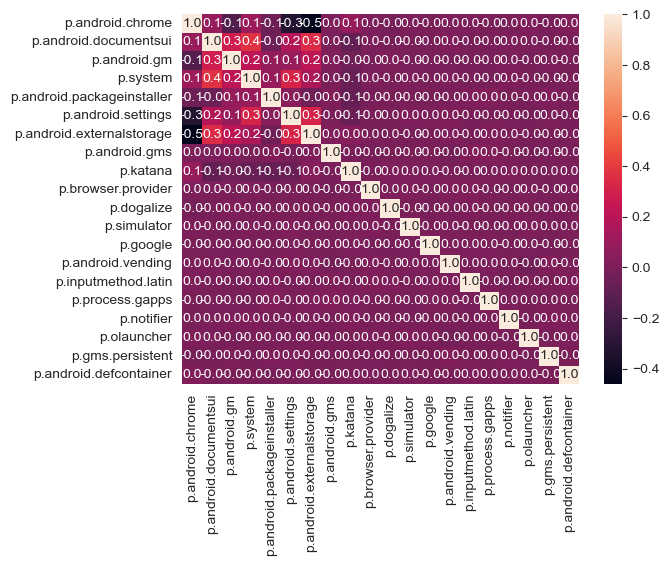

In [5]:
sns.heatmap(processes.iloc[:, 3:].corr(), annot=True, fmt=".1f")

The most prominent correlation is between p.android.chrome and p.android.externalstorage at -0.46 which is on the upper side of moderate correlations. The second most prominent one is between p.system and p.android.documentsui at 0.367, which is on the lower side of moderate correlations and likely to not have any impact.

### Profiles table

In [173]:
categorical_dependency(profiles)

,name,mail,registration,job,ssn,company,current_location,username,residence,address
name,1.000000,0.997888,0.989158,0.998530,1.0,0.989097,1.0,0.991427,1.0,1.0
mail,0.997888,1.000000,0.997845,1.000000,1.0,0.997942,1.0,0.997848,1.0,1.0
registration,0.989158,0.997845,1.000000,0.979535,1.0,0.972479,1.0,0.991351,1.0,1.0
job,0.998530,1.000000,0.979535,1.000000,1.0,0.988458,1.0,0.996875,1.0,1.0
ssn,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.0
company,0.989097,0.997942,0.972479,0.988458,1.0,1.000000,1.0,0.991229,1.0,1.0
current_location,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.0
username,0.991427,0.997848,0.991351,0.996875,1.0,0.991229,1.0,1.000000,1.0,1.0
residence,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.0
address,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.0


We can see that all the data are highly dependent as a user usually has distinct name, mail, ssn, job, etc. Therefore we can infer that if we know one of the values, we can infer the rest.

In [174]:
# we can see that the column with least unique values is job, which is still only 5 profiles per job on average.
for column in profiles.columns:
    print(column, profiles[column].nunique())

name 2549
mail 2594
registration 2304
job 455
ssn 2605
company 2464
current_location 2475
username 2560
imei 496
residence 912
user_id 1644
address 2214


## 1-1D: Pair analysis of predicted variable

### Connections table

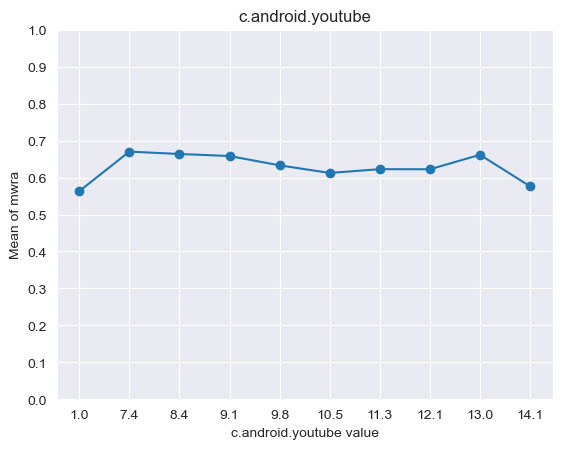

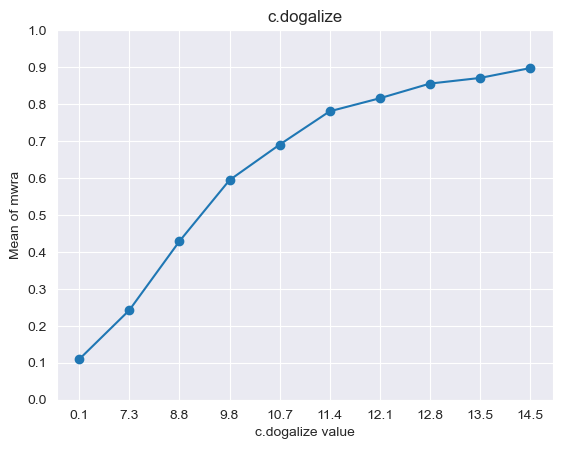

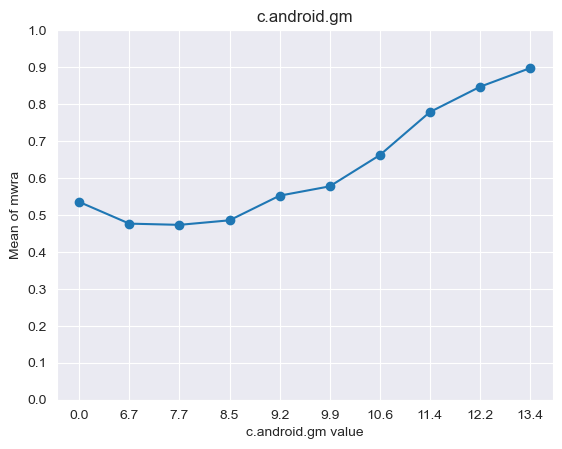

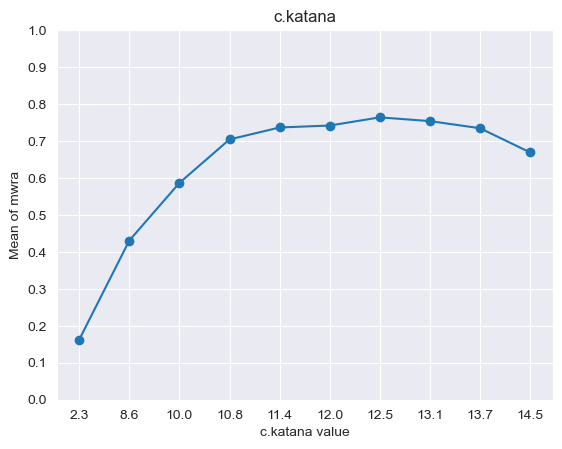

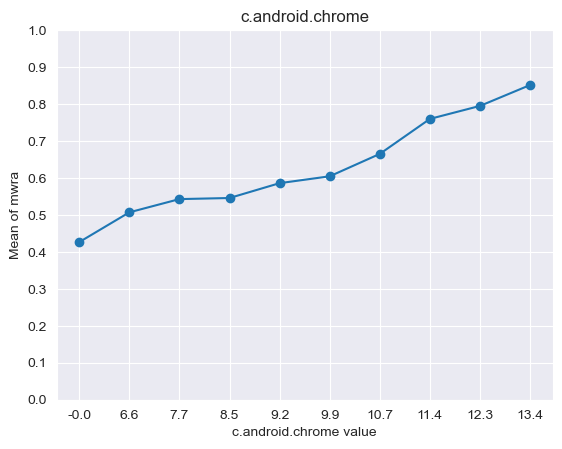

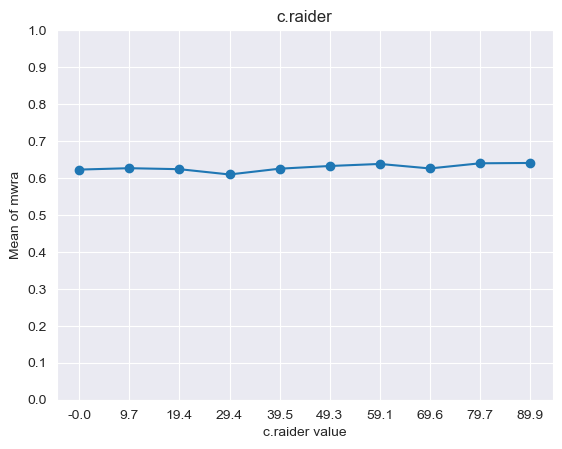

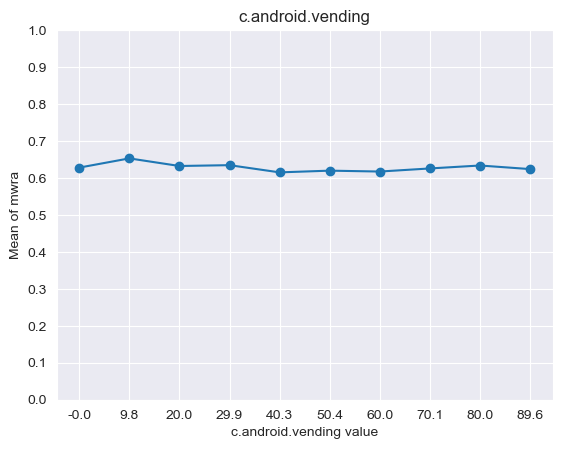

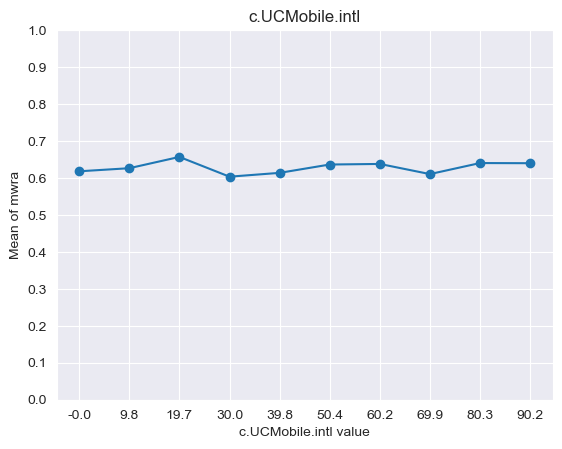

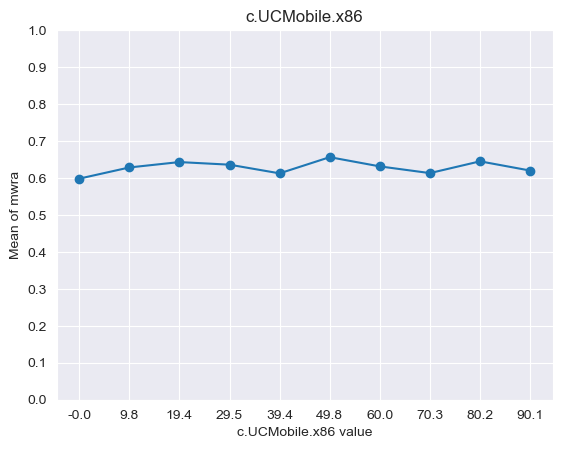

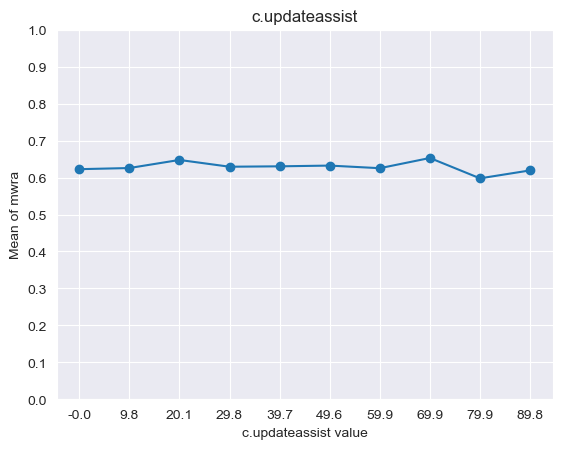

In [175]:
for column in connections.columns[3:]:
    mwra_dependency_num(connections, column)
    plt.title(column)
    plt.show()

We can see columns c.raider, c.android.vending, c.UCMobile.intl, c.UCMobile.x86, c.updateassist don't seem to have any effect on mwra.

Outliers in c.android.youtube seem to have negative effect on mwra and in the middle the values are then slightly above global average.

c.dogalize c.android.gm, c.katana and c.android.chrome seems to have a positive effect on mwra with c.dogalize and c.katana being more logarithmic rather than linear.


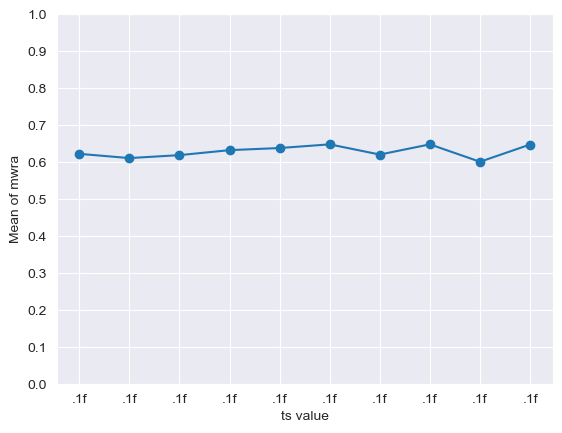

In [176]:
# ts needs to be converted to datetime to be used in the function
connections['ts'] = pd.to_datetime(connections['ts'])
mwra_dependency_num(connections, 'ts')

The graph shows there is no significant change in mwra as time passes.

### Processes table

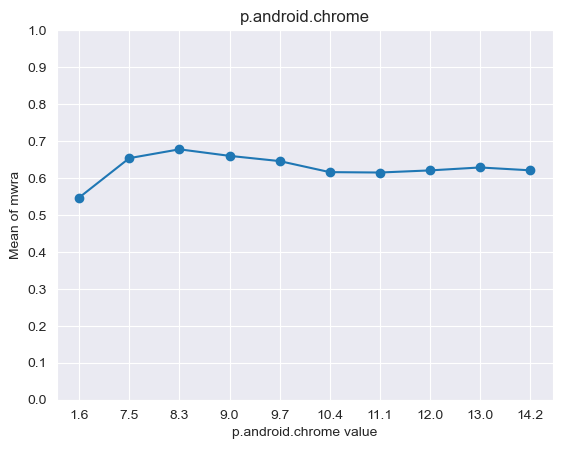

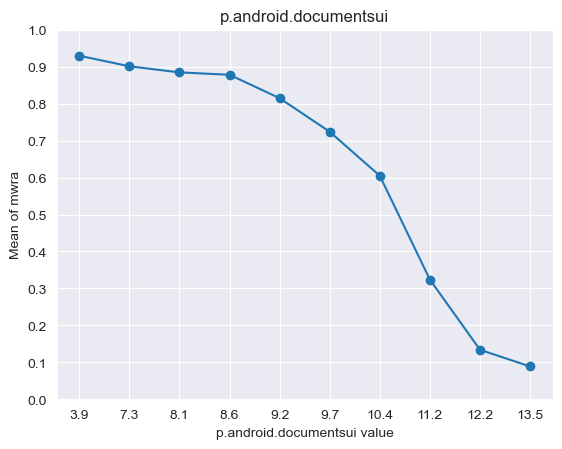

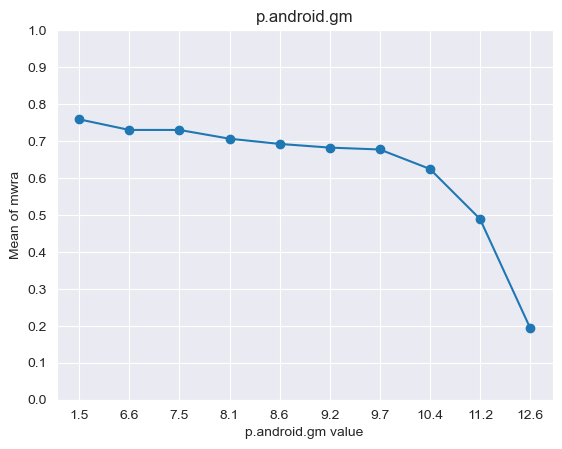

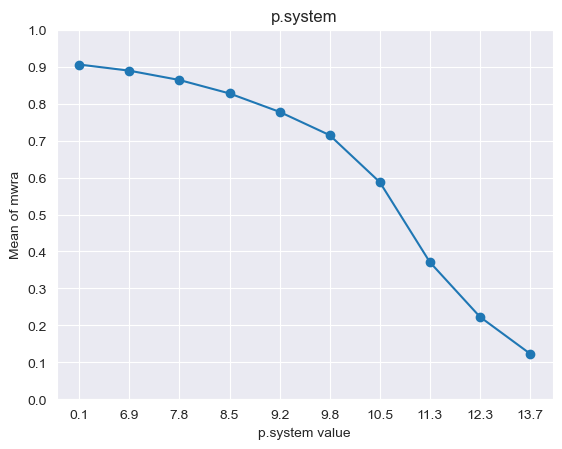

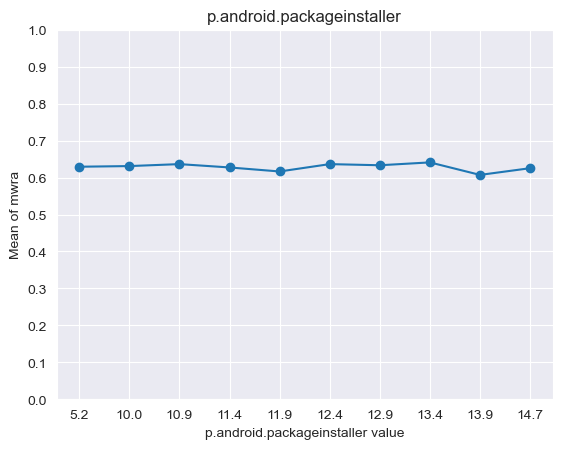

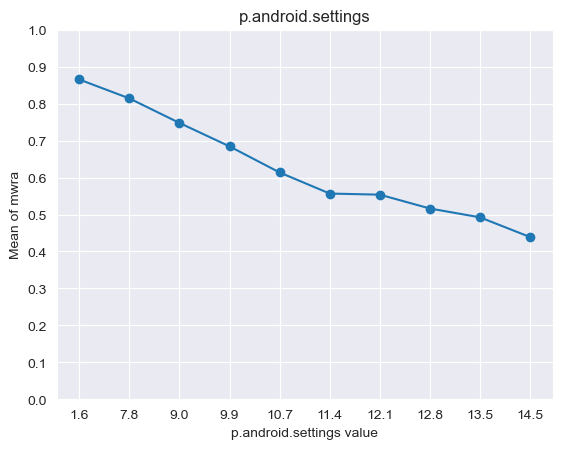

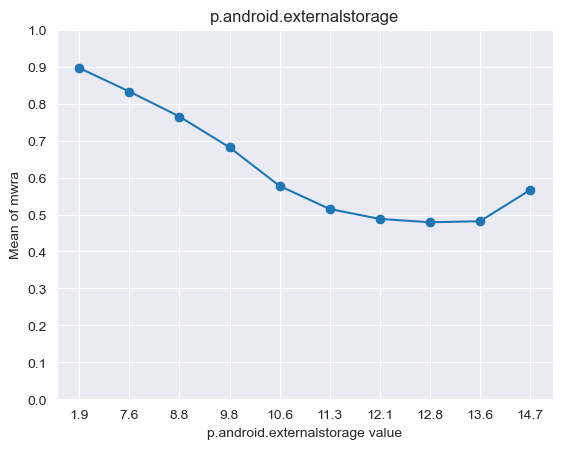

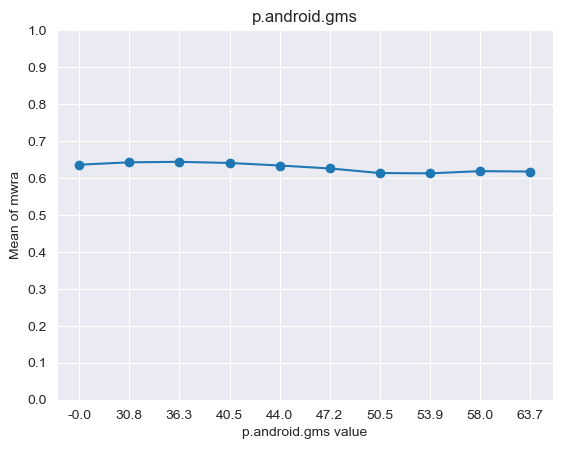

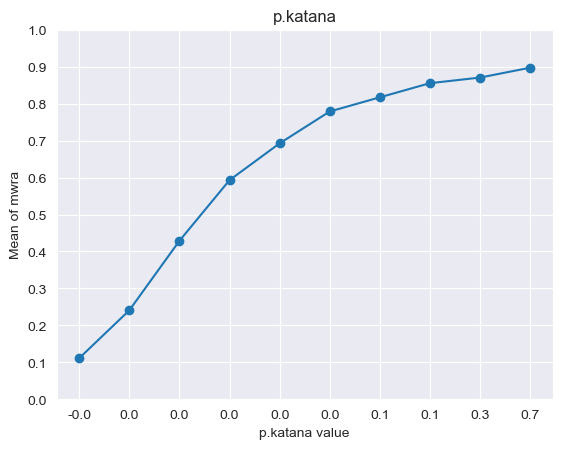

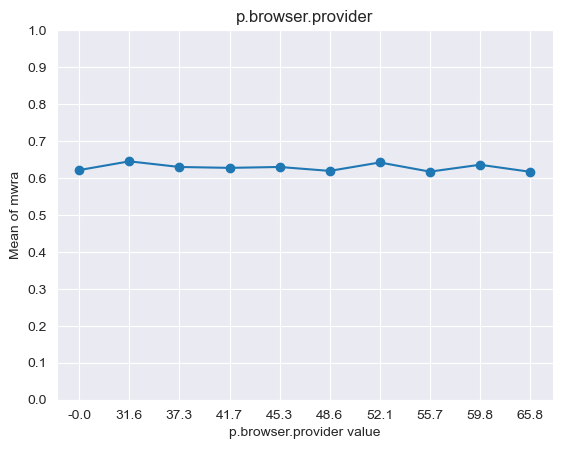

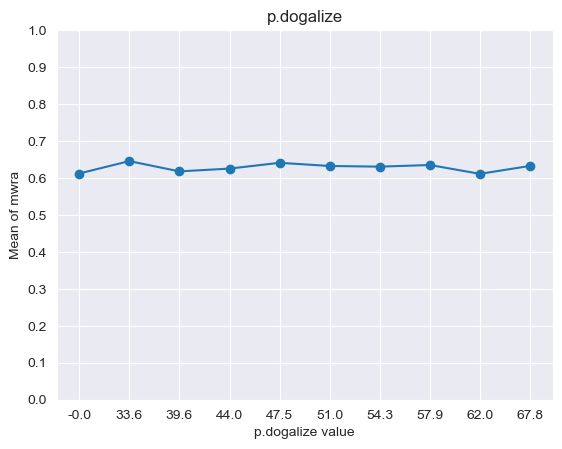

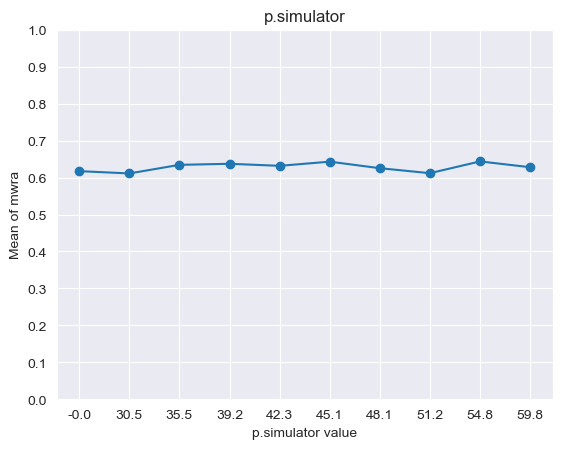

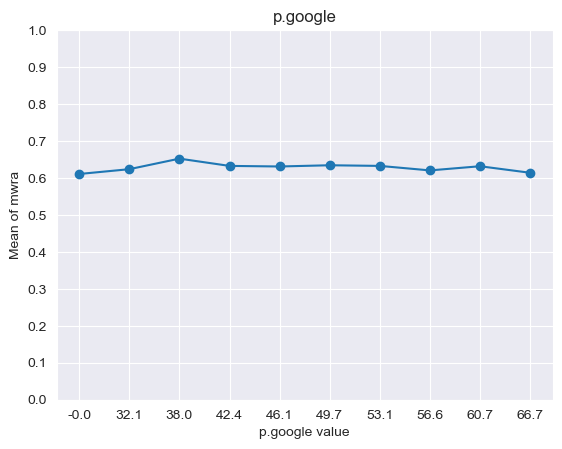

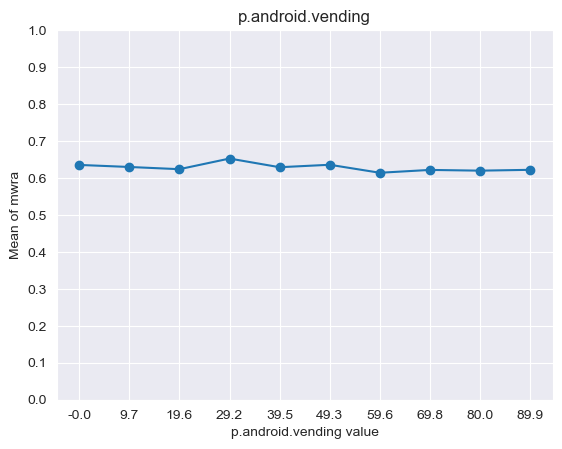

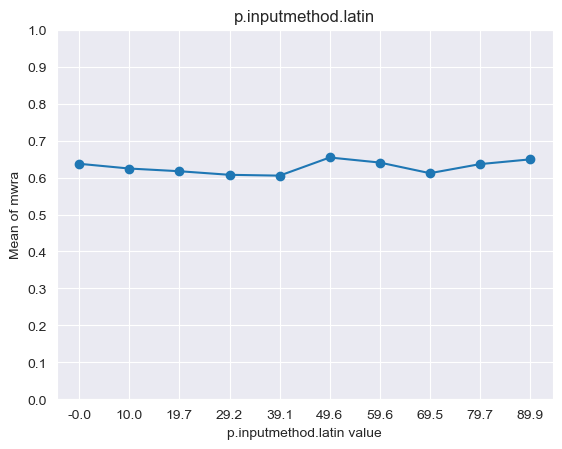

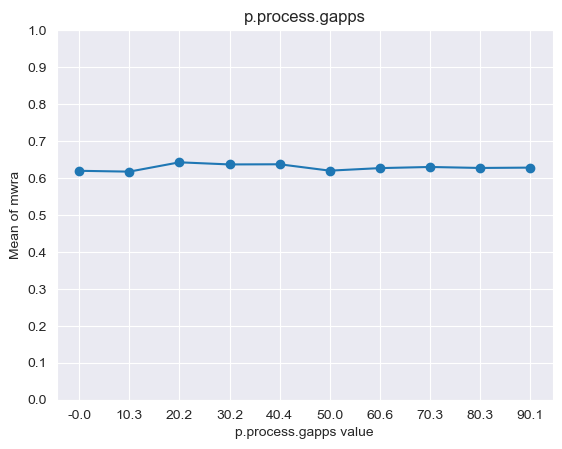

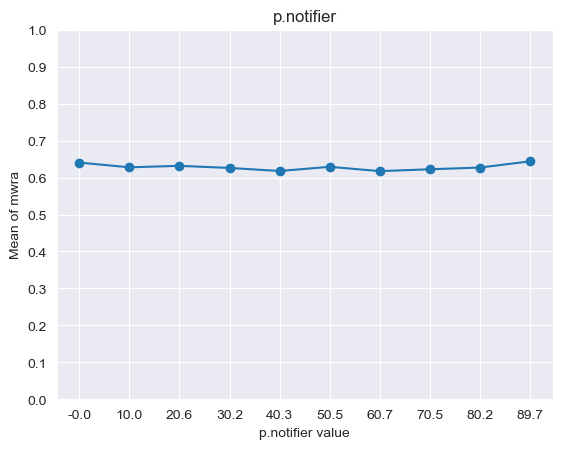

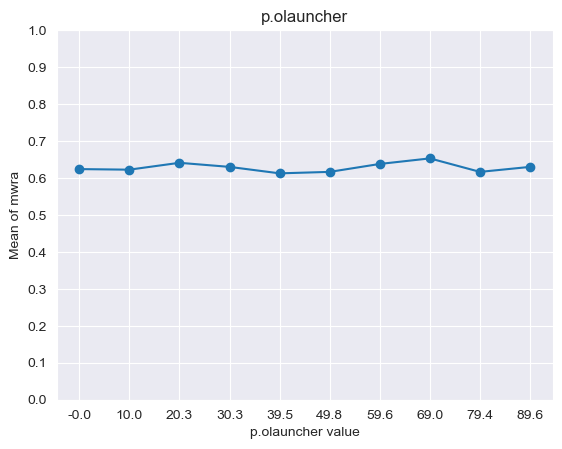

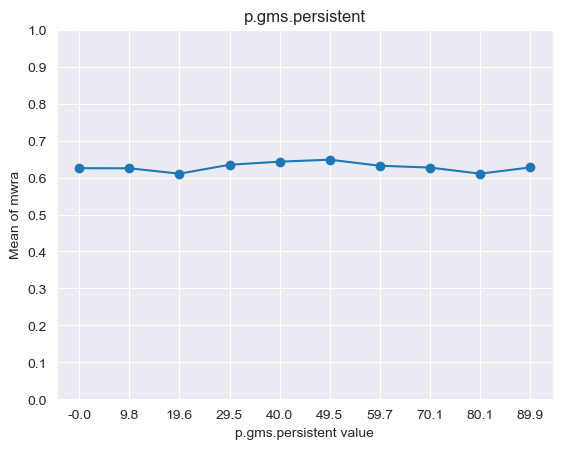

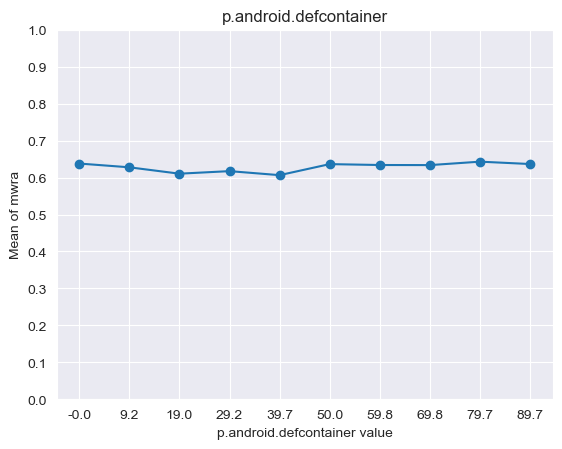

In [177]:
for column in processes.columns[3:]:
    mwra_dependency_num(processes, column)
    plt.title(column)
    plt.show()

Most of the columns in this table seem not to be connected to mwra. 

There are a few that seem to be connected though.
The only one with positive relationship being p.katana.

p.android.externalstorage, p.android.settings, p.system, p.android.documentsui and p.android.gm having negative correlation to mwra being positive.

### Devices and profiles tables

First we need to join them on imei with first imei and mwra columns of either of the tables above (connections, processes) as we need to have them in a table where there is the predicted variable mwra

In [178]:
keys = processes[['imei', 'mwra']]
devices_mwra = pd.merge(keys, devices, on='imei', how='inner')
devices_mwra = devices_mwra.drop(columns=['imei', 'latitude', 'longitude'])
profiles_mwra = pd.merge(keys, profiles.dropna(), on='imei', how='inner') # need to drop na for mutual information to work
profiles_mwra = profiles_mwra.drop(columns='imei')

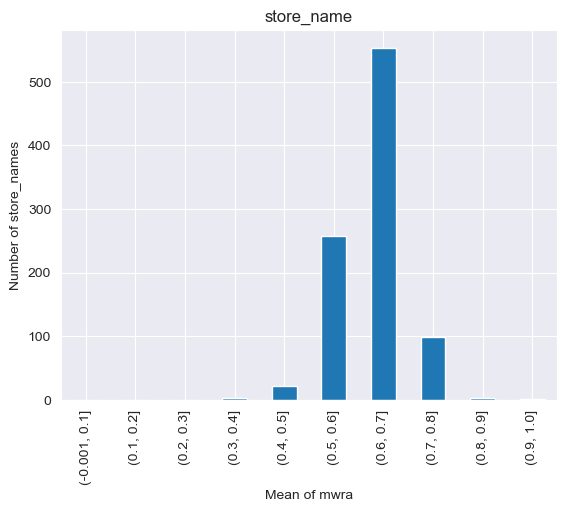

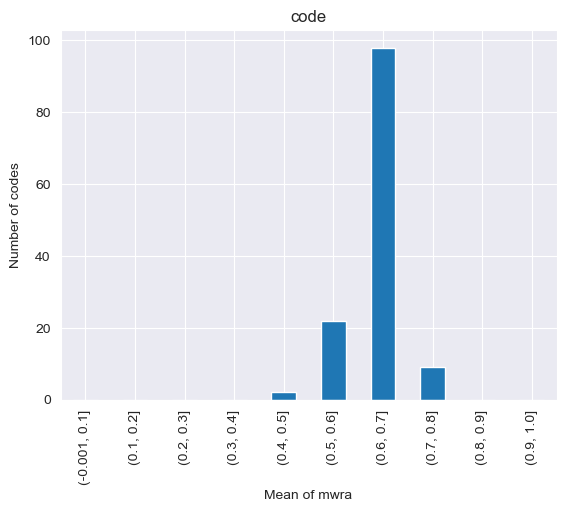

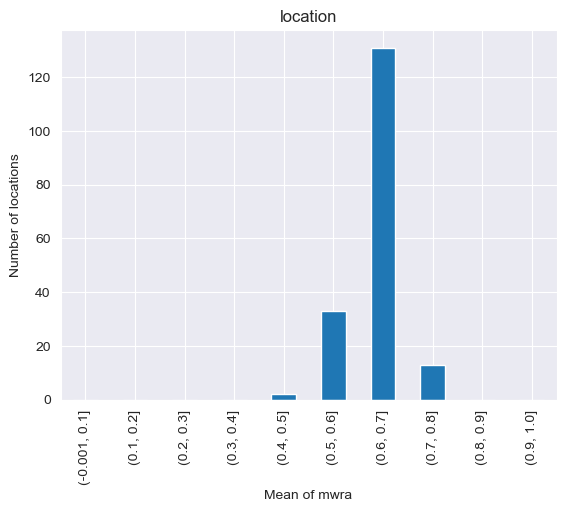

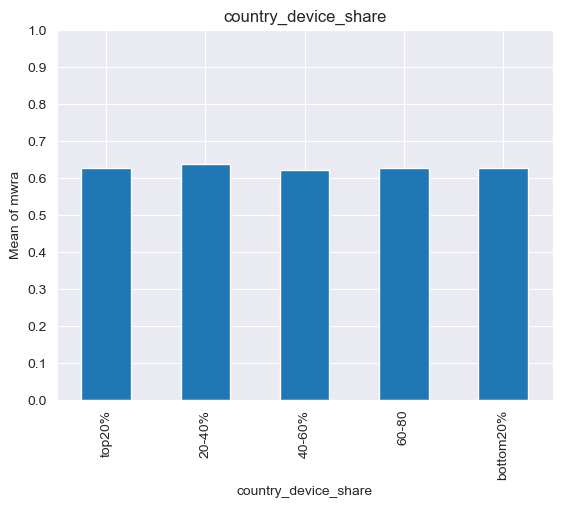

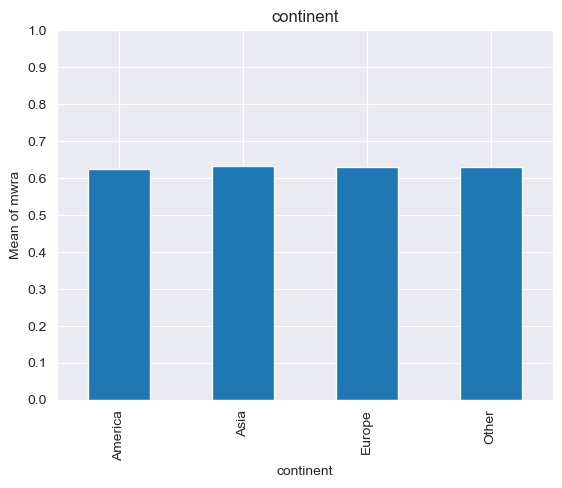

In [179]:
for column in devices_mwra.columns[1:]:
    # for tables with many values, we split into categories
    mwra_dependency_cat(devices_mwra, column, devices_mwra[column].nunique() > 10)
    plt.title(column)
    plt.show()

We can tell that the continent and country_device_share don't affect mwra at all. We can also see that store_name, code and location have the same distribution of how many values in those columns have effect. That's because they are highly dependent. We can also see that most of the values in them (be it countries, stores,...) have same mwra average as the global average. Meaning they likely don't have any significant impact and therefore there aren't useful in out goal of predicting mwra.

We can see that barely any of the countries have an effect on mwra. 

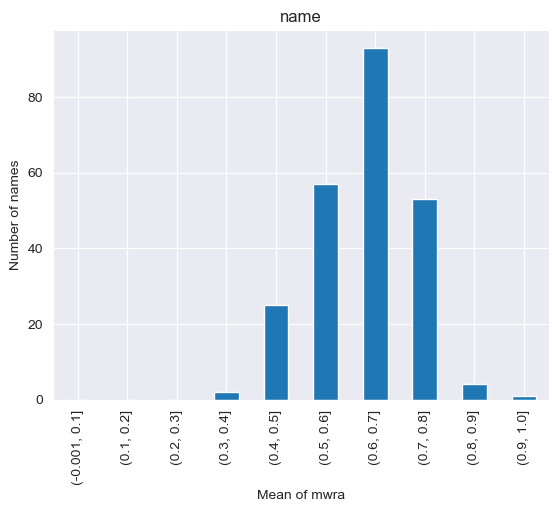

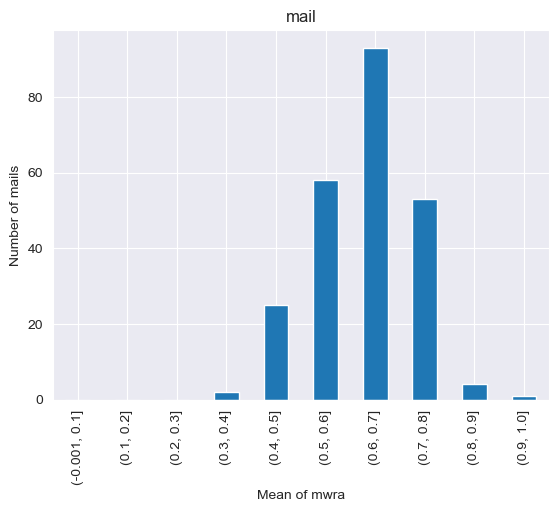

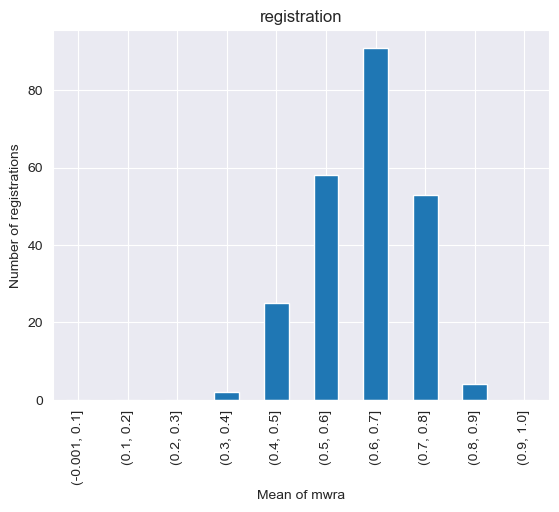

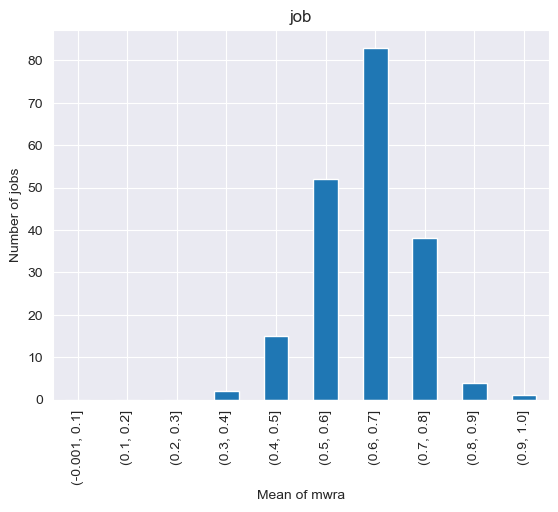

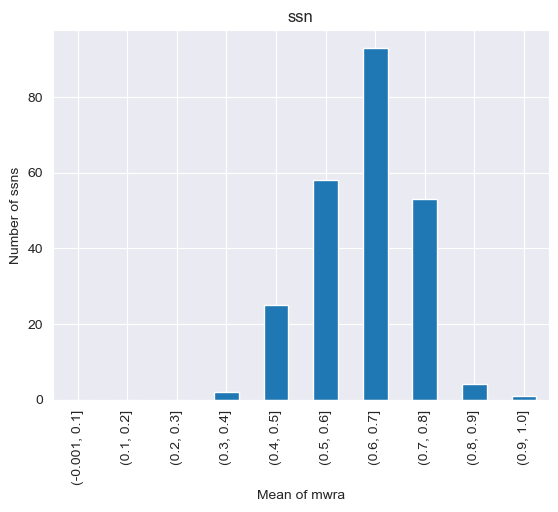

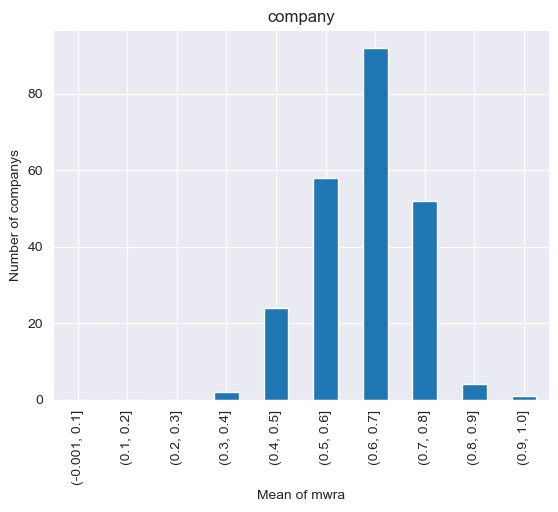

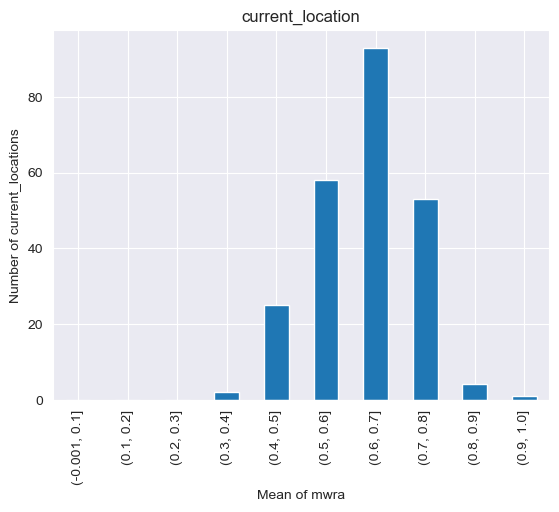

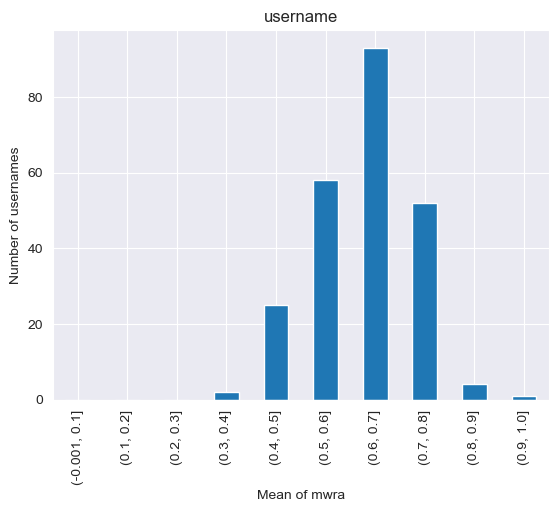

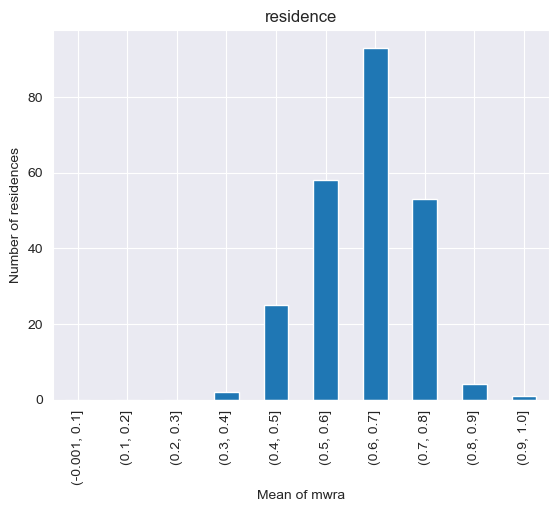

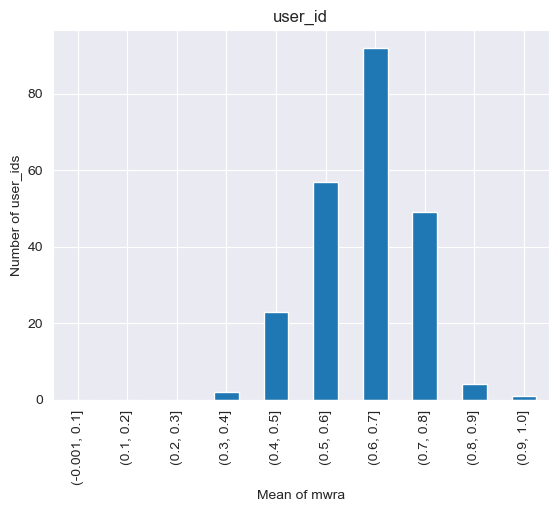

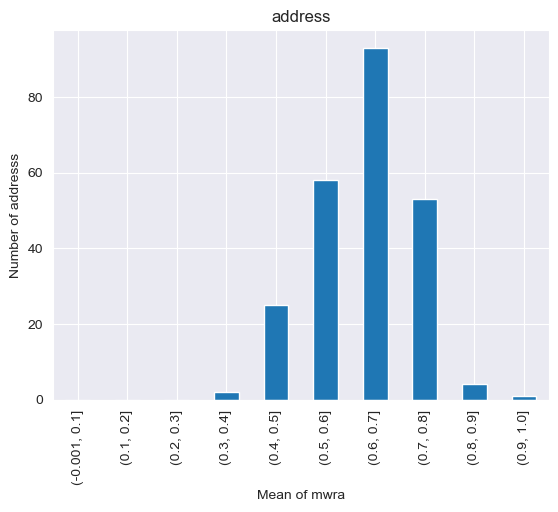

In [180]:
for column in profiles_mwra.columns[1:]:
    # for tables with many values, we split into categories
    mwra_dependency_cat(profiles_mwra, column, profiles_mwra[column].nunique() > 10)
    plt.title(column)
    plt.show()

The columns in profiles data also have the most of the unique values with no effect on mwra. BUT, there's way higher variance compared to columns in devices data.
Let's check normalized mutual information on these columns.

In [181]:
for column in profiles_mwra.columns[1:]:
    print(normalized_mutual_info_score(profiles_mwra[column], profiles_mwra['mwra']))


0.005897303029731395
0.005901346251770889
0.005754012979071085
0.004998144785231974
0.00590134625177089
0.00590560694525427
0.00590134625177089
0.005906003693579377
0.00590134625177089
0.0057393360725882135
0.005901346251770889


In [182]:
print("Normalized mutual information scores:")
for column in profiles_mwra.columns[1:]:
    print(column, normalized_mutual_info_score(profiles_mwra[column], profiles_mwra['mwra']))


Normalized mutual information scores:
name 0.005897303029731395
mail 0.005901346251770889
registration 0.005754012979071085
job 0.004998144785231974
ssn 0.00590134625177089
company 0.00590560694525427
current_location 0.00590134625177089
username 0.005906003693579377
residence 0.00590134625177089
user_id 0.0057393360725882135
address 0.005901346251770889


As it seems, that variability in the graphs was still insignificant, as the normalized mutual information scores are all very close to 0, showing no correlation.

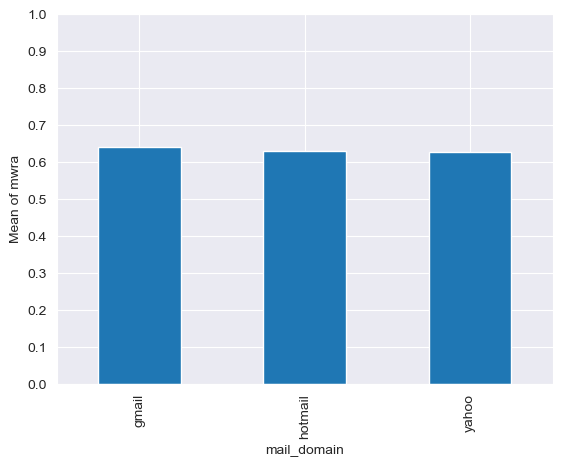

In [183]:
# we can try to extract domain from email address in column mail, to check if perhaps that has any effect on mwra (as logically, one might expect that)
profiles_mwra['mail_domain'] = profiles_mwra['mail'].map(lambda x: x.split('@')[1].split('.')[0])
mwra_dependency_cat(profiles_mwra, 'mail_domain')

As it turns out, the mail domain had no effect at all.

## 1-1E: Summary
In analysis, we discovered many important findings, that will aid us later. 

Tables connections and processes didn't have columns with a lot of outliers, so fixing them shouldn't be that complicated. On the other hand devices contained quite a lot.
The column 'code' had 19 values, whose value count was considered to be outlying. That amounted for 14.5% of unique values and 70.2% of all the rows. Those columns probably won't be used anywhere, as we couldn't simply not use the outliers. Grouping the lower frequency values also wasn't viable, as it was quite strongly correlated to the 'continent' column which we extracted from 'location' column. Other columns in the devices table wouldn't be useful either as the cardinality is way too high and couldn't help in predicting anything.
 
We need to do something about correlating columns. Table connections contained columns c.android.youtube and c.android.gm with -0.42 correlation. Doesn't necessarily mean one of them has to be dropped, since it's only moderate correlation, but needs to be kept track of. Table processes had columns p.android.chrome and p.android.externalstorage at -0.46 which is also quite significant negative correlation.

In tables processes and connections we found some interesting correlations. 

# Phase 1-2


## 1-2A: Initial Data Cleaning
we will be discussing only duplicates and incorrect formats, as we have discussed null values and outliers before and they will be discussed again in 1-2B and 1-2C

### Connections, Processes


In [184]:
print(f"Null rows:\n\tConnections: {connections.isnull().sum().sum()}\n\tProcesses: {processes.isnull().sum().sum()}\nDuplicate rows:\n\tConnections: {connections.duplicated().sum()}\n\tProcesses: {processes.duplicated().sum()}")

Null rows:
	Connections: 0
	Processes: 0
Duplicate rows:
	Connections: 179
	Processes: 179


The tables don't have any null values, but there are duplicates. There is a timestamp column, implying 1 entry every minute. Therefore, we can assess the duplicates aren't just coincidentally same results, but they are accidentally duplicated rows and we can drop them.

In [185]:
connections.drop_duplicates(inplace=True)
processes.drop_duplicates(inplace=True)

Also, datatype of the timestamp columns should be changed to datetime, as they have been treated as strings so far. MWRA is a float, despite it being just a value saying whether malware related activity was present or not. Therefore we can change the type to boolean.

In [186]:
connections['ts'] = pd.to_datetime(connections['ts'])
processes['ts'] = pd.to_datetime(processes['ts'])
connections['mwra'] = connections['mwra'].astype(bool)
processes['mwra'] = processes['mwra'].astype(bool)

It looks like processes and connections have the same length and the same values in the columns ts, imei, mwra in respective rows. Let's check if this is true.

In [187]:
(connections[['ts', 'imei', 'mwra']] == processes[['ts', 'imei', 'mwra']]).all().all() # .all().all() checks if all values across both dimensions are True

True

Previous cell has confirmed our suspicion, that these were the same snapshots. We can now join the tables

In [188]:
actions = processes.join(connections.drop(columns=['ts', 'imei', 'mwra']), how='inner')

In [189]:
actions['imei'].nunique(), processes['imei'].nunique(), connections['imei'].nunique()

(500, 500, 500)

### Devices

In [190]:
print(f"Null rows: {devices.isnull().sum().sum()}\nDuplicate rows: {devices.duplicated().sum()}")

Null rows: 0
Duplicate rows: 12


There are 12 duplicates in the devices table. We can drop them.

In [191]:
devices.drop_duplicates(inplace=True)

As a part of cleanup, we also split the location column into continent and city.

In [192]:
devices['continent'] = devices['location'].map(lambda x: x.split('/')[0])
devices.rename(columns={'location': 'city'}, inplace=True)

### Profiles

In [193]:
print(f"Null values: {profiles.isnull().sum().sum()}\nDuplicate rows: {profiles.duplicated().sum()}")

Null values: 4037
Duplicate rows: 0


There are no duplicate rows, but a lot of null values. We will have to deal with them in section 1-2B.

Current location should be split into latitude and longitude columns as to match with devices table.

In [194]:
profiles['latitude'] = profiles['current_location'].map(lambda x: float(x.split("'")[1]) if pd.notna(x) else np.nan)
profiles['longitude'] = profiles['current_location'].map(lambda x: float(x.split("'")[3]) if pd.notna(x) else np.nan)
profiles.drop(columns='current_location', inplace=True)

In [195]:
profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2605 entries, 0 to 2604
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          2605 non-null   object 
 1   mail          2605 non-null   object 
 2   registration  2605 non-null   object 
 3   job           782 non-null    object 
 4   ssn           2605 non-null   object 
 5   company       2605 non-null   object 
 6   username      2605 non-null   object 
 7   imei          2605 non-null   int64  
 8   residence     912 non-null    object 
 9   user_id       2605 non-null   int64  
 10  address       2214 non-null   object 
 11  latitude      2475 non-null   float64
 12  longitude     2475 non-null   float64
dtypes: float64(2), int64(2), object(9)
memory usage: 264.7+ KB


Next we set the registration date to uniform format and rename it to registration_date to be more clear.

In [196]:
profiles['registration_date'] = pd.to_datetime(profiles['registration'], format='mixed', dayfirst=False)
profiles.drop(columns='registration', inplace=True)

In [197]:
profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2605 entries, 0 to 2604
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               2605 non-null   object        
 1   mail               2605 non-null   object        
 2   job                782 non-null    object        
 3   ssn                2605 non-null   object        
 4   company            2605 non-null   object        
 5   username           2605 non-null   object        
 6   imei               2605 non-null   int64         
 7   residence          912 non-null    object        
 8   user_id            2605 non-null   int64         
 9   address            2214 non-null   object        
 10  latitude           2475 non-null   float64       
 11  longitude          2475 non-null   float64       
 12  registration_date  2605 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2), object(8)
memory us

User ID isn't unique for users, so that should get fixed, but we are dropping that later anyway, as there wasn't any proven correlation between that and .

## 1-2B: Handling Missing Values
Only missing values in the table are in profiles table in columns job, residence, address and latitude/longitude (coming from current_location).

### Removing missing values
done simply with:

In [198]:
p_na_removed = profiles.dropna()

### Imputing missing values

#### Jobs

In [199]:
jobs_random_impute = profiles['job'].apply(lambda x: np.random.choice(profiles['job'].dropna()) if pd.isna(x) else x)
jobs_mode_impute = profiles['job'].fillna(profiles['job'].mode()[0])
jobs_impute_as_other = profiles['job'].fillna('Other')
print(f"We can see that other and mode don't work as there are more null values than not null ones. If we imputed null as 'other', there would be {jobs_impute_as_other.value_counts().max()} values and only {profiles['job'].dropna().shape[0]} non-null values. With mode it would be the same + small amount of the mode value ({jobs_mode_impute.value_counts().max()})")

We can see that other and mode don't work as there are more null values than not null ones. If we imputed null as 'other', there would be 1823 values and only 782 non-null values. With mode it would be the same + small amount of the mode value (1829)


Let's check if random imputation would make sense

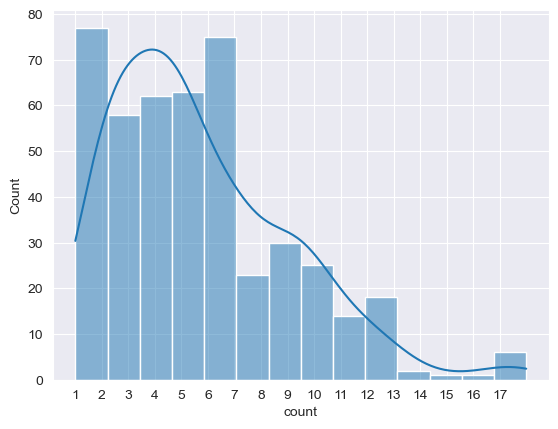

In [200]:
sns.histplot(jobs_random_impute.value_counts(), kde=True)
plt.xticks(np.arange(1, jobs_random_impute.value_counts().max(), 1))
plt.show()

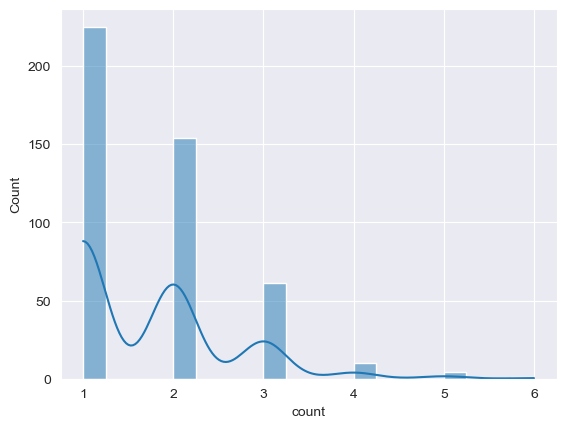

In [201]:
sns.histplot(profiles['job'].value_counts(), kde=True)
plt.show()

We can see that if we imputed random values, the distribution would change slightly.

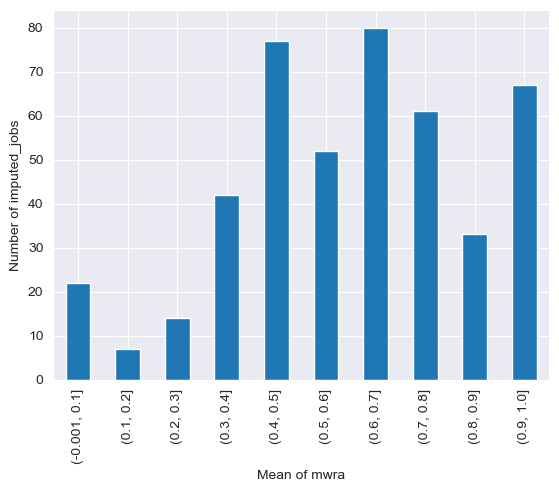

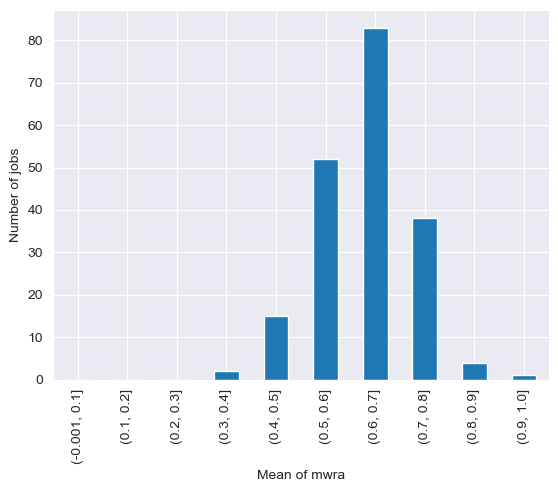

In [202]:
profiles_mwra['imputed_job'] = jobs_random_impute
mwra_dependency_cat(profiles_mwra, 'imputed_job', True)
plt.show()
mwra_dependency_cat(profiles_mwra, 'job', True)
plt.show()

We can also see that it's relation to mwra would change drastically.

Either way, as there are so many missing values, in a column, that isn't deducible from other columns, we don't have any way to use it.

#### Residence and address
Initial thought is they are likely to be the same, so we can check that.

In [203]:
p_na_removed[(p_na_removed['residence'] == p_na_removed['address'])]

,name,mail,job,ssn,company,username,imei,residence,user_id,address,latitude,longitude,registration_date


We found that isn't the case, so we can't substitute one with the other for missing values.

Let's try the same methods as in the job column

In [204]:
profiles['residence'].value_counts().max(), profiles['address'].value_counts().max()

(1, 1)

We can see residence and address are unique values. Therefore mode and 'other' imputations wouldn't work as it would outweigh all the other values. Random imputation would work only in a sense, where we would generate random strings as addresses, but at that point it's pointless as it would be just another id for a profile.  

Another solution would be to extract the state from the address. The null values could be retreived using classification with knn, based on longitude and latitude.

In [205]:
profiles['state'] = profiles['address'].str.extract(r'([A-Z]{2}) \d{5}')
knn_data = profiles[['latitude', 'longitude', 'state']].copy()
knn_data['state_encoded'] = pd.factorize(knn_data['state'])[0]

# Use KNNImputer to impute missing values in the 'state_encoded' column
imputer = KNNImputer(n_neighbors=5)
knn_imputed = imputer.fit_transform(knn_data[['latitude', 'longitude', 'state_encoded']])

# Convert the imputed state back to categorical (from the encoded numeric values)
knn_data['state_imputed'] = pd.Series(pd.factorize(knn_data['state'])[1][knn_imputed[:, 2].astype(int)])

# Fill in the original missing state values with the imputed ones
profiles['state'] = profiles['state'].fillna(knn_data['state_imputed'])
profiles.head()

,name,mail,job,ssn,company,username,imei,residence,user_id,address,latitude,longitude,registration_date,state
0,Matthew Powell,floreseugene@yahoo.com,NaN,219-60-6090,Hicks-Drake,kcalderon,3590433799317661974,NaN,2401,"84859 Nunez Lock Suite 082\nWest Rossside, HI ...",-27.447495,-43.231283,2024-03-14,HI
1,Nicole Richards,fthompson@gmail.com,NaN,049-88-9351,"Nguyen, White and Lopez",pgarcia,8630330696303481198,"662 Christopher Point\nWest Matthew, VT 84352",1147,"9123 Traci Pines\nLindastad, ME 99569",39.235450,138.429324,2023-01-13,ME
2,Andrew Smith,megan89@yahoo.com,NaN,039-54-7186,Navarro-Goodman,sramos,8630330696303482071,"9912 Jasmine Extension Suite 310\nDianeville, ...",459,"523 Suarez Port Apt. 013\nKellybury, MS 63150",-22.094944,-141.211383,2019-04-17,MS
3,Shane Williams,osimmons@hotmail.com,"Administrator, Civil Service",453-34-1867,"Brown, Compton and Thompson",ioneill,863033069630348826,NaN,1587,"4827 Morgan Mission\nWest Michaelborough, AL 1...",39.965278,-39.378417,2023-09-09,AL
4,Patricia Leach,prodriguez@yahoo.com,NaN,785-50-4993,Pratt PLC,michaelhart,359043379931766403,NaN,2312,"48666 William View\nEricbury, OH 12135",NaN,NaN,2018-01-30,OH


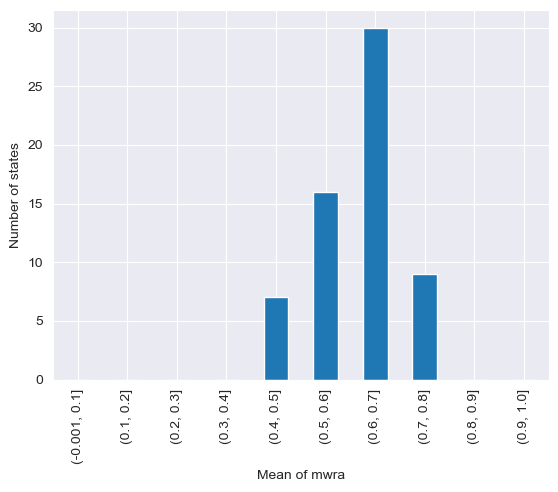

In [206]:
# now let's try to see if the column has any effect on mwra
profiles_mwra['state'] = profiles['state']
mwra_dependency_cat(profiles_mwra, 'state', True)

The state column doesn't have any effect on mwra. We have tried all sorts of imputations and none of them worked. Therefore we can't use the column.

### Latitude and longitude
This location is also unique per row. The values are discrete and not continuous, so we can't use any imputation methods. 

### Summary
We have tried multiple imputation methods, but none of them worked. We can either drop empty rows (which is most of the rows, which isn't ideal) or drop the columns.

## 1-2C: Handling Outliers

### Removing outliers vs capping outliers

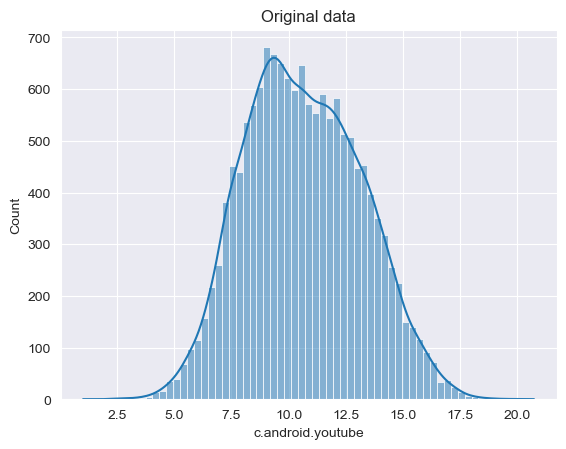

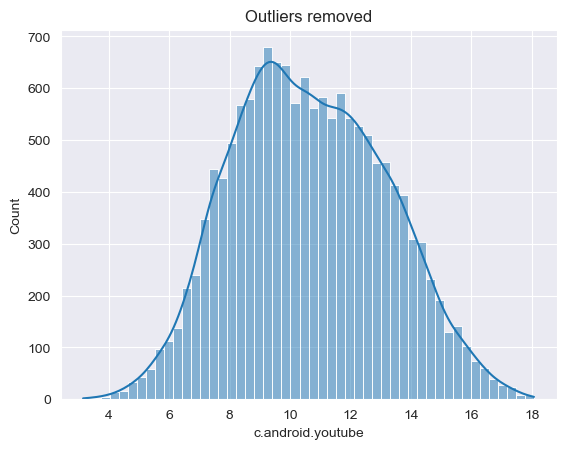

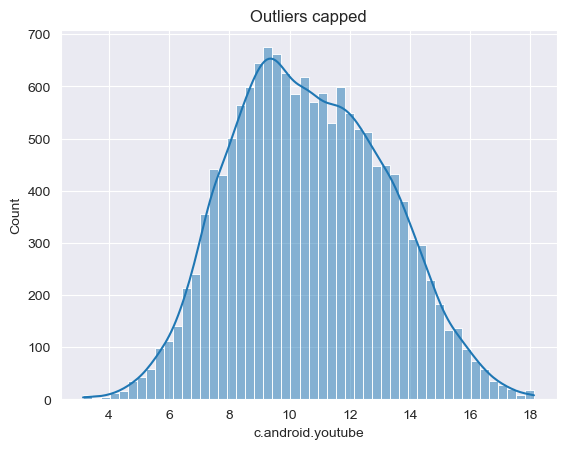

In [207]:
Q1 = connections['c.android.youtube'].quantile(0.25)
Q3 = connections['c.android.youtube'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

connections_no_outliers = connections[(connections['c.android.youtube'] >= lower_bound) & 
                                      (connections['c.android.youtube'] <= upper_bound)]
connections_capped_outliers = connections['c.android.youtube'].clip(lower=lower_bound, upper=upper_bound)

sns.histplot(connections['c.android.youtube'], kde=True)
plt.title('Original data')
plt.show()
sns.histplot(connections_no_outliers['c.android.youtube'], kde=True)
plt.title('Outliers removed')
plt.show()
sns.histplot(connections_capped_outliers, kde=True)
plt.title('Outliers capped')
plt.show()



In the column above, c.android.youtube, both transformations worked well, as there wasn't that many outliers. We can check if we can apply it on all columns.

In [208]:
for column in connections.columns[3:]:
    print(f"{column}: {round(get_outliers(connections[column]).shape[0]/connections[column].shape[0], 4)*100}% are outliers")

c.android.youtube: 0.11% are outliers
c.dogalize: 0.77% are outliers
c.android.gm: 0.16999999999999998% are outliers
c.katana: 1.83% are outliers
c.android.chrome: 0.24% are outliers
c.raider: 0.0% are outliers
c.android.vending: 0.0% are outliers
c.UCMobile.intl: 0.0% are outliers
c.UCMobile.x86: 0.0% are outliers
c.updateassist: 0.0% are outliers


We can see that in connections table, none of the columns have significant amount of outliers (other than c.katana, all are almost 0% outliers). Therefore we can apply the same transformation to all columns.

In [209]:
for column in processes.columns[3:]:
    print(f"{column}: {round(get_outliers(processes[column]).shape[0]/processes[column].shape[0]*100, 2)}% are outliers")

p.android.chrome: 0.26% are outliers
p.android.documentsui: 0.55% are outliers
p.android.gm: 2.67% are outliers
p.system: 0.69% are outliers
p.android.packageinstaller: 0.85% are outliers
p.android.settings: 0.26% are outliers
p.android.externalstorage: 0.33% are outliers
p.android.gms: 0.53% are outliers
p.katana: 14.54% are outliers
p.browser.provider: 0.58% are outliers
p.dogalize: 0.58% are outliers
p.simulator: 0.62% are outliers
p.google: 0.69% are outliers
p.android.vending: 0.0% are outliers
p.inputmethod.latin: 0.0% are outliers
p.process.gapps: 0.0% are outliers
p.notifier: 0.0% are outliers
p.olauncher: 0.0% are outliers
p.gms.persistent: 0.0% are outliers
p.android.defcontainer: 0.0% are outliers


In most columns, the outlier amount is so low, it doesn't cause any problems to apply the transformations. In column p.katana though, 14.54% of values are outliers.  

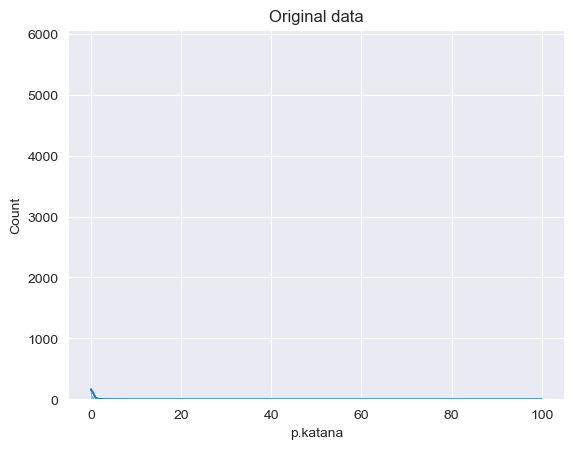

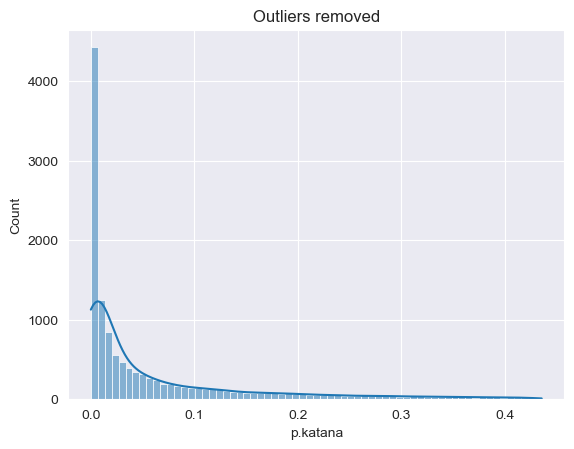

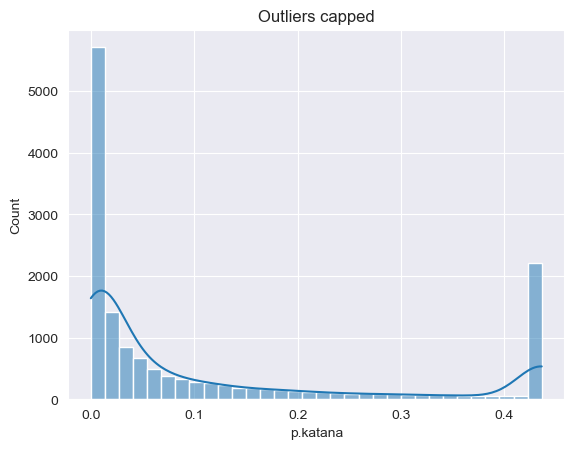

In [210]:
# for the sake of demonstration, we will only show the transformation on p.katana
Q1 = processes['p.katana'].quantile(0.25)
Q3 = processes['p.katana'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

processes_no_outliers = processes[(processes['p.katana'] >= lower_bound) & 
                                      (processes['p.katana'] <= upper_bound)]
processes_capped_outliers = processes['p.katana'].clip(lower=lower_bound, upper=upper_bound)

sns.histplot(processes['p.katana'], kde=True)
plt.title('Original data')
plt.show()
sns.histplot(processes_no_outliers['p.katana'], kde=True)
plt.title('Outliers removed')
plt.show()
sns.histplot(processes_capped_outliers, kde=True)
plt.title('Outliers capped')
plt.show()

# Phase 1-3 Hypothesis testing

## 1-3A: 1st hypothesis
Null hypothesis H0: p.android.documentsui is equal or greater on devices with malware-related-activity.  
Alternative hypothesis H1: p.android.documentsui is lower on devices with malware-related-activity.

For this hypothesis, let's just deal with outliers by removing them.

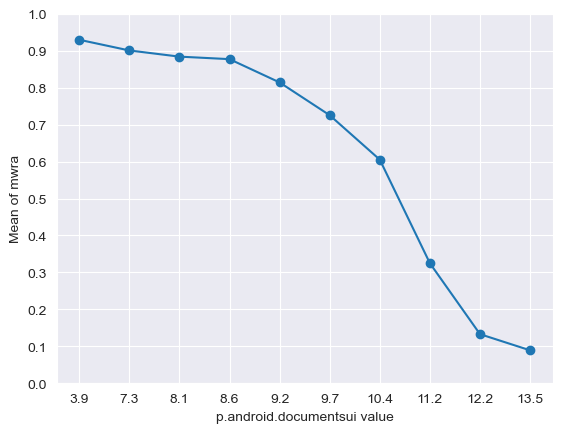

In [211]:
Q1 = processes['p.android.documentsui'].quantile(0.25)
Q3 = processes['p.android.documentsui'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

processes['p.android.documentsui'] = processes['p.android.documentsui'].clip(lower=lower_bound, upper=upper_bound)
mwra_dependency_num(processes, 'p.android.documentsui')

As we can see from the graph, there seems to be obvious correlation between the two. Let's check it with a t-test (or Mann-Whitney U test, if the doesn't meet assumptions for t-test).

### Checking assumptions for t-test

First, to even t-test, we have to have two numerical columns to compare their means. We manage that by splitting p.android.documentsui into two groups based on mwra.

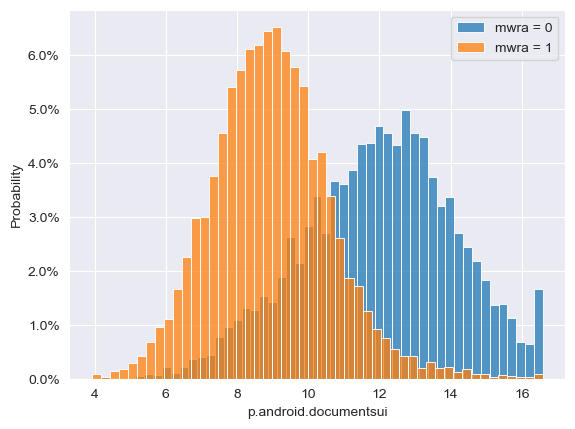

In [212]:
PADwithoutMalware = processes[processes['mwra'] == False]['p.android.documentsui']
PADwithMalware = processes[processes['mwra'] == True]['p.android.documentsui']
sns.histplot(PADwithoutMalware, bins=50, stat='probability')
sns.histplot(PADwithMalware, bins=50, stat='probability')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.legend(['mwra = 0', 'mwra = 1'])
plt.show()

We can see that the mean of values with positive mwra is more to the left, hinting at a negative correlation. 
Both look normally distributed, but the one with mwra = 1 has higher kurtosis, while the other one is slightly skewed.

Let's check whether the variances are the same (to see which t-test to use) with Levene test.

In [213]:
stats.levene(PADwithoutMalware, PADwithMalware)

LeveneResult(statistic=476.56000675736084, pvalue=5.0851815577092043e-104)

As the p-value is very low, we can see that the variances are not the same. Therefore we couldn't assume same differences and we would have to use a different formula for t-test.

Let's check the normality of the data with Shapiro-Wilk test.

In [214]:
stats.shapiro(PADwithoutMalware), stats.shapiro(PADwithMalware)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5537.
  res = hypotest_fun_out(*samples, **kwds)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 9358.
  res = hypotest_fun_out(*samples, **kwds)


(ShapiroResult(statistic=0.9936461921439426, pvalue=5.4103049268543724e-15),
 ShapiroResult(statistic=0.98432991943794, pvalue=7.4324155108853815e-31))

As we got really low p-values, we can see that this data is not usable in t-test.

### Mann-Whitney U test

In [215]:
stats.mannwhitneyu(PADwithoutMalware, PADwithMalware, alternative='greater')

MannwhitneyuResult(statistic=44524517.0, pvalue=0.0)

#### As the p-value is close to 0, we can __reject__ the null hypothesis, that there is no statistical significance of p.android.documentsui having influence on malware-related-activity.

## 1-3A: 2nd hypothesis
Null hypothesis H0: p.dogalize has no influence on malware-related-activity.
Alternative hypothesis H1: p.dogalize has influence on malware-related-activity.

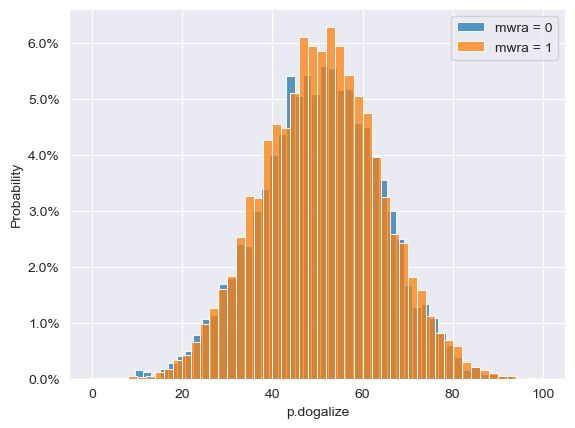

In [216]:
PGwithoutMalware = processes[processes['mwra'] == False]['p.dogalize']
PGwithMalware = processes[processes['mwra'] == True]['p.dogalize']
sns.histplot(PGwithoutMalware, bins=50, stat='probability')
sns.histplot(PGwithMalware, bins=50, stat='probability')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.legend(['mwra = 0', 'mwra = 1'])
plt.show()

The means, same as the distributions seem to be overlapping, so we can't infer anything from the graph.

### Checking assumptions for t-test

Let's check the variances with Levene test.

In [217]:
stats.levene(PGwithoutMalware, PGwithMalware)

LeveneResult(statistic=1.1183785133840245, pvalue=0.2902850228265554)

The p-value is high, so we can assume the variances are the same, therefore one assumption for independent samples t-test is met.

In [218]:
stats.shapiro(PGwithoutMalware), stats.shapiro(PGwithMalware)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5537.
  res = hypotest_fun_out(*samples, **kwds)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 9358.
  res = hypotest_fun_out(*samples, **kwds)


(ShapiroResult(statistic=0.9994419788288147, pvalue=0.09228017033985167),
 ShapiroResult(statistic=0.9998092405614641, pvalue=0.6144633148723971))

As we want confidence level of at least 95%, we can't refuse neither of the hypotheses, confirming distributions are normal.

Now as the assumptions are met, we can do the t-test.

### T-test

In [219]:
stats.ttest_ind(PGwithoutMalware, PGwithMalware)

TtestResult(statistic=-0.7578823407691168, pvalue=0.4485334145530929, df=14893.0)

#### We failt to reject the null hypothesis, that there is no influence of p.dogalize on malware-related-activity, as the p-value is way higher than 0.05.

## 1-3B Confirming statistical power
Impacting factors:
* sample size
* effect size
* significance level
* variance

### Sample sizes
to get sample sizes, we just get the size of the series

In [220]:
print(f"Sample sizes:\nHypothesis 1:\n\tmwra=0: {PADwithoutMalware.shape[0]}\n\tmwra=1: {PADwithMalware.shape[0]}\nHypothesis 2:\n\tmwra=0:  {PGwithoutMalware.shape[0]}\n\tmwra=1: {PGwithMalware.shape[0]}")

Sample sizes:
Hypothesis 1:
	mwra=0: 5537
	mwra=1: 9358
Hypothesis 2:
	mwra=0:  5537
	mwra=1: 9358


### Effect size
To calculate effect size, we can use Cohen's d.

In [221]:
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2) 
    
    # calculate the variance of the samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)

    # calculate the pooled standard deviation
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2)) 
    
    # calculate the means of the samples
    u1, u2 = np.mean(d1), np.mean(d2)
    
    # calculate the effect size
    d = (u1 - u2) / s 
    return d

In [222]:
cohend(PADwithoutMalware, PADwithMalware), cohend(PGwithoutMalware, PGwithMalware)

(1.5801152403155707, -0.012849708018448966)

### Now we can calculate the powers of the tests

#### Hypothesis 1

In [223]:
n1 = PADwithoutMalware.shape[0] 
n2 = PADwithMalware.shape[0]
effect_size = cohend(PADwithoutMalware, PADwithMalware)
alpha = 0.05 # standard
alternative = 'larger'

TTestIndPower().solve_power(effect_size=effect_size, nobs1=n1, alpha=alpha, alternative=alternative)

1.0

From the power being 1.0, we can see that the test is very powerful. It means 0% chance of making a Type II error.

#### Hypothesis 2

In [224]:
n1 = PGwithoutMalware.shape[0]
n2 = PGwithMalware.shape[0]
effect_size = cohend(PGwithoutMalware, PGwithMalware)
alpha = 0.05 

TTestIndPower().solve_power(effect_size=effect_size, nobs1=n1, alpha=alpha)

0.10378009630042015

The power of 0.10 means that the test is not powerful enough. 